# Estimativa da geracão instantânea (nowcasting) de painéis solares a partir de imagens do céu
### Gustavo Friol Bento (20250477)


### Projeto final da disciplina Tópicos Avançados em Controle processos de sinais IV - Prof. Danilo Silva

## EDA Inicial

**Observações:** O dataset consiste em um arquvio HDF5 com dois grupos: 'trainval' e 'test', onde cada grupo possui dois datasets: "images_log" e "pv_log", os quais armazenam as imagens e dados de geração FV, correspondendo ao período de 2017-2019. Além disso, temos também dois arquivos .npy que armazenam os time stamps de ambos os datasets de treinamento/validação e teste.

Portanto, os dataset já está particionado em treinamento\validação e teste. Além disso, os autores do dataset SKIPP'D também já fizeram um pré-processamento dos dados, que pode ser resumido nas etapas seguintes:

1. Processamento do Histórico Bruto de Geração FV

- Interpolação dos dados FV para cada 10 segundos (em preparação para o casamento com imagens com time stamps irregulares, por exemplo, 08:20:40)
- Filtragem de dados FV inválidos (registros ausentes > 1 hora ou dados FV < 0)

2. Processamento de Imagens e Casamento de Imagens com Dados FV Concorrentes
- Redimensionamento das imagens - 2048 x 2048 para 64 x 64
- Filtragem de imagens repetidas causadas pelo comportamento anormal ocasional da função de captura de vídeo do OpenCV

3. Particionamento dos Conjuntos de Treino/Validação e Teste

Dessa forma, o dataset consiste em 3 anos de imagens 64x64 com geração FV concorrente em um intervalo de 1 min.

In [1]:
import numpy as np
import os
import shutil
import time
import random
import datetime
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-07-08 05:45:08.942456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751953509.127563      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751953509.182563      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Explorando o arquivo HDF5 no Kaggle

In [2]:
data_folder = "/kaggle/input/skippd"
data_path = os.path.join(data_folder, "2017_2019_images_pv_processed.hdf5")
times_trainval_path = os.path.join(data_folder, "times_trainval.npy")
times_test_path = os.path.join(data_folder, "times_test.npy")


print("data_folder:", data_folder)
print("data_path:", data_path)
print("times_trainval_path:", times_trainval_path)
print("times_test_path:", times_test_path)

data_folder: /kaggle/input/skippd
data_path: /kaggle/input/skippd/2017_2019_images_pv_processed.hdf5
times_trainval_path: /kaggle/input/skippd/times_trainval.npy
times_test_path: /kaggle/input/skippd/times_test.npy


In [3]:
skippd_dataset = h5py.File(data_path, 'r')

def get_all(name):
    if name!=None:
        print(skippd_dataset[name])

skippd_dataset.visit(get_all)

<HDF5 group "/test" (2 members)>
<HDF5 dataset "images_log": shape (14003, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (14003,), type "<f8">
<HDF5 group "/trainval" (2 members)>
<HDF5 dataset "images_log": shape (349372, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (349372,), type "<f8">


#### Carregando os time stamps do conjunto de trainval no notebook.

In [7]:
times_trainval = np.load(times_trainval_path, allow_pickle=True)
print('times_trainval shape:', times_trainval.shape)
times_trainval

times_trainval shape: (349372,)


array([datetime.datetime(2017, 3, 9, 6, 47),
       datetime.datetime(2017, 3, 9, 6, 48),
       datetime.datetime(2017, 3, 9, 6, 49), ...,
       datetime.datetime(2019, 10, 26, 17, 57, 20),
       datetime.datetime(2019, 10, 26, 17, 58, 20),
       datetime.datetime(2019, 10, 26, 17, 59, 20)], dtype=object)

In [8]:
times_test = np.load(times_test_path, allow_pickle=True)
print('times_test_shape:', times_test.shape)
times_test

times_test_shape: (14003,)


array([datetime.datetime(2017, 9, 15, 7, 11),
       datetime.datetime(2017, 9, 15, 7, 12),
       datetime.datetime(2017, 9, 15, 7, 13), ...,
       datetime.datetime(2019, 10, 19, 18, 13, 30),
       datetime.datetime(2019, 10, 19, 18, 14, 30),
       datetime.datetime(2019, 10, 19, 18, 15, 30)], dtype=object)

#### Visualizando algumas imagens.

In [9]:
trainval_set = skippd_dataset['trainval']
test_set = skippd_dataset['test']
print(trainval_set.keys())
print(test_set.keys())

<KeysViewHDF5 ['images_log', 'pv_log']>
<KeysViewHDF5 ['images_log', 'pv_log']>


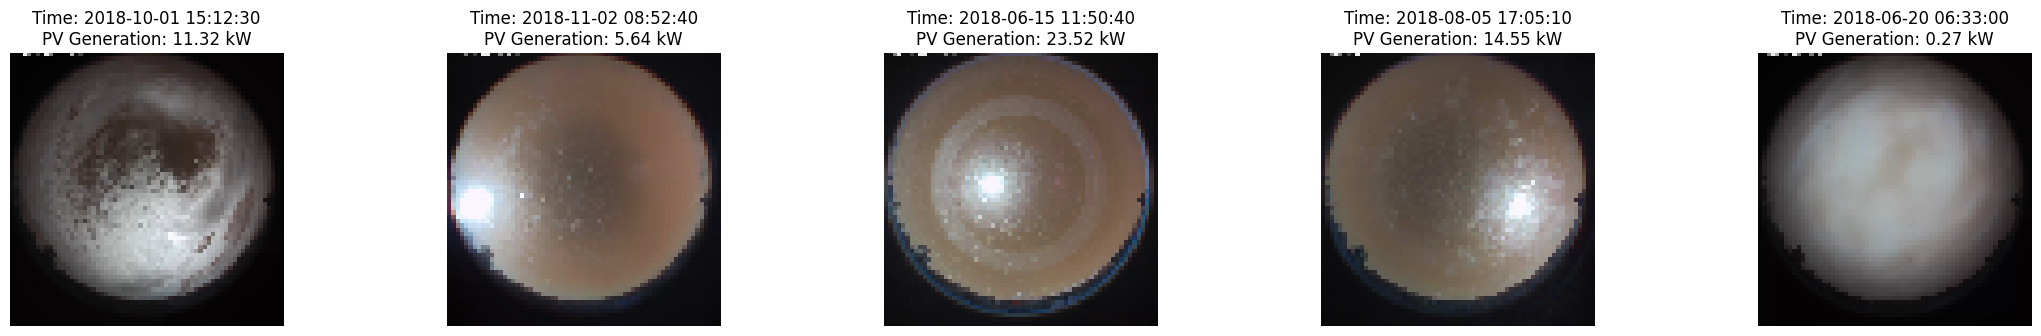

In [11]:
pv_out = trainval_set['pv_log']
sky_photos = trainval_set['images_log']

random_idx = [random.randint(1, 349372) for _ in range(5)]

plt.figure(figsize=(22, 15))

for n, i in enumerate(random_idx):
    plt.subplot(5, 5, n+1) 

    plt.imshow(sky_photos[i])
    plt.axis('off') 

    time_val = times_trainval[i]
    pv_gen_val = pv_out[i]
    plt.title(f"Time: {time_val}\nPV Generation: {pv_gen_val:.2f} kW")

plt.tight_layout() 
plt.show()

### Histograma dos dados de geração PV para os conjuntos de teste e treinamento/validação.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


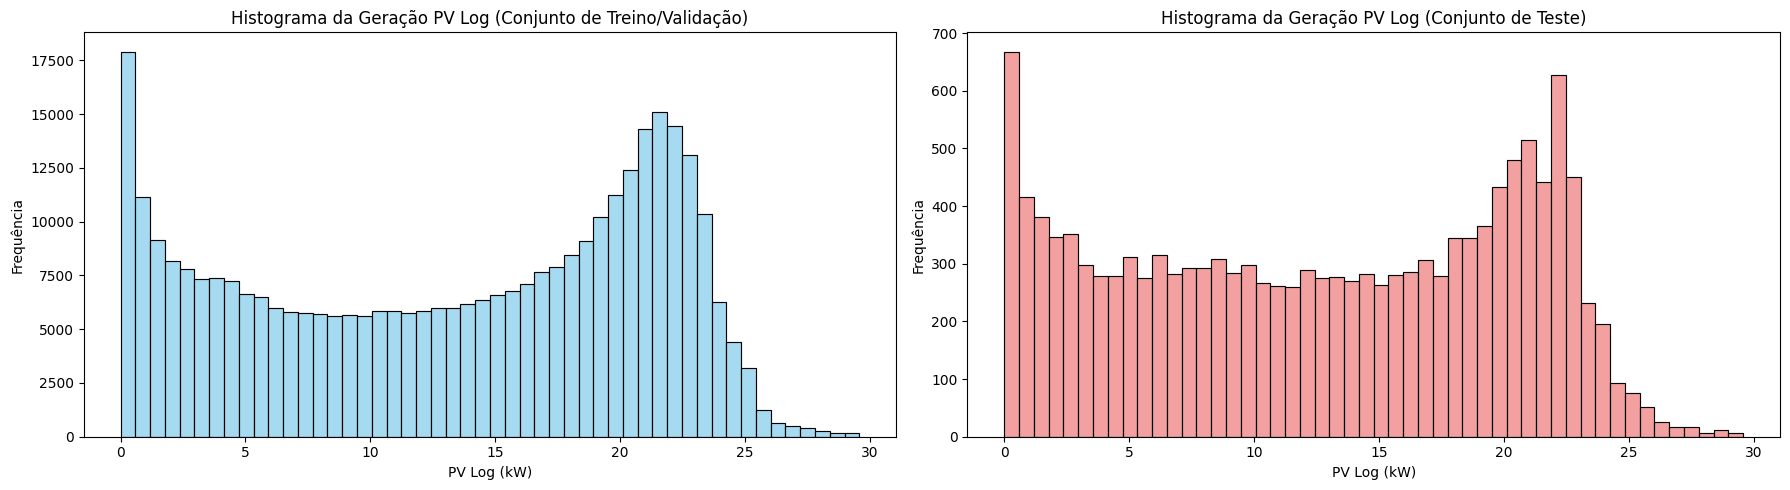

In [8]:
pv_out_trainval = trainval_set['pv_log']
pv_out_test = test_set['pv_log']

pv_out_trainval = np.array(trainval_set['pv_log'])
pv_out_test = np.array(test_set['pv_log'])

plt.figure(figsize=(18, 5)) 

# Subplot 1: Histograma para pv_out_trainval
plt.subplot(1, 2, 1) 
sns.histplot(pv_out_trainval, bins=50, color='skyblue')
plt.title('Histograma da Geração PV Log (Conjunto de Treino/Validação)')
plt.xlabel('PV Log (kW)')
plt.ylabel('Frequência')

# Subplot 2: Histograma para pv_out_test
plt.subplot(1, 2, 2) 
sns.histplot(pv_out_test, bins=50, color='lightcoral')
plt.title('Histograma da Geração PV Log (Conjunto de Teste)')
plt.xlabel('PV Log (kW)')
plt.ylabel('Frequência')

plt.tight_layout() 
plt.show()

### Explorando a partição entre conjunto de teste e treinamento/validação.

In [9]:
# Extrair apenas as datas de cada timestamp
dates_trainval = np.array([ts.date() for ts in times_trainval])
dates_test = np.array([ts.date() for ts in times_test])

# Obter as datas únicas de cada conjunto
unique_dates_trainval = set(dates_trainval)
unique_dates_test = set(dates_test)

# Encontrar a intersecção das datas únicas
overlapping_dates = unique_dates_trainval.intersection(unique_dates_test)

if len(overlapping_dates) > 0:
    print(f"ATENÇÃO: Vazamento de dados detectado! Os seguintes dias estão presentes em ambos os conjuntos:")
    for date in sorted(list(overlapping_dates)):
        print(date)
else:
    print("Não foi detectado vazamento de dados por dia entre os conjuntos de treinamento/validação e teste.")

print(f"\nNúmero de dias únicos no conjunto de treinamento/validação: {len(unique_dates_trainval)}")
print(f"Número de dias únicos no conjunto de teste: {len(unique_dates_test)}")

Não foi detectado vazamento de dados por dia entre os conjuntos de treinamento/validação e teste.

Número de dias únicos no conjunto de treinamento/validação: 497
Número de dias únicos no conjunto de teste: 20


In [23]:
unique_dates_test

{datetime.date(2017, 6, 24),
 datetime.date(2017, 9, 15),
 datetime.date(2017, 9, 20),
 datetime.date(2017, 10, 6),
 datetime.date(2017, 10, 11),
 datetime.date(2017, 10, 22),
 datetime.date(2018, 1, 25),
 datetime.date(2018, 2, 16),
 datetime.date(2018, 3, 9),
 datetime.date(2018, 6, 12),
 datetime.date(2018, 6, 23),
 datetime.date(2018, 10, 4),
 datetime.date(2019, 1, 25),
 datetime.date(2019, 5, 27),
 datetime.date(2019, 6, 23),
 datetime.date(2019, 6, 28),
 datetime.date(2019, 7, 14),
 datetime.date(2019, 8, 10),
 datetime.date(2019, 10, 14),
 datetime.date(2019, 10, 19)}

In [22]:
len(unique_dates_trainval)

497

Podemos observar que a separação entre os dados de treinamento foi feita de forma correta, mantendo amostras com alto grau de correlação (mesmo dia) em conjuntos distintos. Dessa forma, não há vazamento de informação para o conjunto de teste e o modelo está apto a ser treinado.

## Arquitetura do Modelo - SUNSET

Definição da arquitetura do modelo SUNSET, apresentado no artigo abaixo: 

Sun, Y., Szűcs, G., Brandt, A.R., 2018. Solar PV output prediction from video streams using convolutional neural networks. Energy Environ. Sci. 11, 1811–1818.

In [10]:
# get the input dimension for constructing the model
img_side_len = skippd_dataset['trainval']['images_log'].shape[1]
num_color_channel = skippd_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

image side length: 64
number of color channels: 3
input image dimension: [64, 64, 3]


In [11]:
# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define the model architecture using tf.keras API
def sunset_model():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = keras.Input(shape=image_input_dim)

    ## 1st convolution block
    x = keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## two fully connected nets
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model
    model = keras.Model(inputs=x_in,outputs=y_out)

    return model

# show model architecture
sunset_model().summary()

2025-06-24 12:01:41.529454: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 24)          │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 48)          │          10,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      12,583,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,645,937 (52.06 MB)

 Trainable params: 13,645,793 (52.05 MB)

 Non-trainable params: 144 (576.00 B)

## Desenvolvimento - SUNSET

Abaixo, temos uma função para criação dos datasets em cada fold. O valor 5000 para o buffer size foi escolhido devido à limitações de memória RAM do Kaggle. Armazenar o conjunto de treino inteiro no buffer para um embaralhamento completo consome muita memória RAM. Após alguns testes foi constatado que o valor 5000 demonstrou ser um valor razoável.  

In [12]:
def create_dataset(is_test, batch_size, images_np, pv_np):
   
    def preprocess_data(image, pv_value):
        image = tf.image.convert_image_dtype(image, tf.float32) 
        pv_value = tf.cast(pv_value, tf.float32)
        return image, pv_value

    dataset = tf.data.Dataset.from_tensor_slices((images_np, pv_np))
    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

    if is_test:
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    else:
        shuffle_buffer_size = 5000 
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

Função para plotar as curvas de treinamento e validação durante o processo de validação cruzada no grid search.

In [13]:
def plot_training_history(history, fold_name="", lr=None, bs=None):
    plt.figure(figsize=(12, 5))

    title_suffix = ""
    if lr is not None: title_suffix += f" LR={lr}"
    if bs is not None: title_suffix += f" BS={bs}"

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Loss de Treinamento')
    if 'val_loss' in history: plt.plot(history['val_loss'], label='Loss de Validação')
    plt.title(f'{fold_name} - Loss (MSE){title_suffix}')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['mae'], label='MAE de Treinamento')
    if 'val_mae' in history: plt.plot(history['val_mae'], label='MAE de Validação')
    plt.title(f'{fold_name} - MAE{title_suffix}')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Definição de uma função para obter os dados de treinamento e validação para cada fold. A função é contruída para garantir que o split seja feito em um array contendo as datas únicas do conjunto. Ao fazer esse split com base nas datas, podemos garantir que não há vazamento de informações entre os dados de treinamento e validação.

In [14]:
def cv_split(unique_dates, date_to_indices, train_indices, val_indices, pv_np, images_np):
    """
     Função que retorna os dados de treinamento e validação para cada fold.
     A função deve ser chamada a cada fold.
     
     - unique_dates: array contendo as datas únicas presentes no conjunto.
     - date_to_indices: dicionário contendo que agrupa os índices do conjunto por data.
     - train_indices e val_indices: índices de cada fold fornecidos pelo kf.split, onde o split é feito no array unique_dates.
     - pv_np e images_np: arrays np carregados do arquivo hdf5.
     """

    # Obter as datas reais para o fold
    train_dates = [unique_dates[i] for i in train_indices]
    val_dates = [unique_dates[i] for i in val_indices]
    
    # Obter os índices reais das amostras para o fold
    train_real_indices = np.concatenate([date_to_indices[d] for d in train_dates])
    val_real_indices = np.concatenate([date_to_indices[d] for d in val_dates])

    # Filtrar os arrays np com base nos índices para o fold
    train_images = images_np[train_real_indices]
    train_pv = pv_np[train_real_indices]
    val_images = images_np[val_real_indices]
    val_pv = pv_np[val_real_indices]
    
    return train_images, train_pv, val_images, val_pv

Função para fazer a validação cruzada k-fold e exibir os resultados de cada fold. Ela engloba as funções create_dataset, cv_split e plot_training_history definidas anteriormente.

In [15]:
def cross_val(unique_dates, date_to_indices, pv_np, images_np, learning_rate, batch_size, reduce_lr_patience, earlystop_patience, num_epochs, k_splits):
    
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42) # shuffle=True para aleatorizar os dias entre folds
    
    fold_histories = []
    fold_eval_results = []
    
    print(f"\nIniciando treinamento com {k_splits}-Fold Cross-Validation (por dia)...")
    
    # Iterar sobre os folds de DATAS
    for fold_idx, (train_date_indices, val_date_indices) in enumerate(kf.split(unique_dates)):
        print(f"\n--- Iniciando Fold {fold_idx + 1}/{k_splits} ---")
        keras.backend.clear_session()

        # Obter split para o fold atual utilizando a função cv_split
        fold_train_images, fold_train_pv, fold_val_images, fold_val_pv = cv_split(unique_dates, date_to_indices, train_date_indices, val_date_indices, pv_np, images_np)
        
        # Crie os datasets tf.data para o fold atual
        train_dataset_fold = create_dataset(is_test=False, batch_size=batch_size, images_np=fold_train_images, pv_np=fold_train_pv)
        val_dataset_fold = create_dataset(is_test=True, batch_size=batch_size, images_np=fold_val_images, pv_np=fold_val_pv)
    
        # Chamando e compilando o modelo Sunset
        model = sunset_model()
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
        # Definindo callbacks
        earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_patience, min_lr=1e-6, verbose=1)
    
        # Treinando e armazenando o histórico para cada fold
        history = model.fit(train_dataset_fold, epochs=num_epochs, validation_data=val_dataset_fold, callbacks=[earlystop, reduce_lr],verbose=1)
        fold_histories.append(history.history)
        
        # Plotando histórico
        plot_training_history(history.history, fold_name=f"Fold {fold_idx + 1}")
    
        print(f"\nAvaliação do Fold {fold_idx + 1} no conjunto de validação:")
        val_loss, val_mae = model.evaluate(val_dataset_fold, verbose=0)
        print(f"Loss (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}")
        fold_eval_results.append({'loss': val_loss, 'mae': val_mae})

    # Juntando os resultados de todos os folds
    print("\n--- Resumo dos Resultados do K-Fold ---")
    for i, results in enumerate(fold_eval_results):
        print(f"Fold {i + 1}: Loss (MSE) = {results['loss']:.4f}, MAE = {results['mae']:.4f}")
    
    avg_mae = np.mean([r['mae'] for r in fold_eval_results])
    avg_loss = np.mean([r['loss'] for r in fold_eval_results])
    print(f"\nMédia de MAE de Validação nos {k_splits} Folds: {avg_mae:.4f}")
    print(f"Média de Loss (MSE) de Validação nos {k_splits} Folds: {avg_loss:.4f}")
    
    return avg_mae, avg_loss, fold_histories

Iremos fazer validação k-fold nas datas únicas, assim é possível garantir que não há vazamento entre o conjunto de treinamento e teste para cada fold.

In [16]:
def grid_search(learning_rates_to_test, batch_sizes_to_test, unique_dates, date_to_indices, pv_np, images_np, num_epochs, k_splits, reduce_lr_patience, earlystop_patience):
    
    # Variáveis para armazenar os melhores resultados
    best_mae = float('inf')
    best_params = None
    best_model_history_overall = None # Para armazenar o histórico do melhor modelo
    
    all_grid_search_results = {} # Para armazenar { (lr, bs): {'avg_mae': X, 'avg_loss': Y, 'histories': [...] } }
    
    print(f"\nIniciando o Grid Search de Hiperparâmetros com {k_splits}-Fold Cross-Validation...")
    
    for lr in learning_rates_to_test:
        for bs in batch_sizes_to_test:
            print(f"\n========================================================")
            print(f"Testando Combinação: Learning Rate = {lr}, Batch Size = {bs}")
            print(f"========================================================")
    
            avg_mae, avg_loss, fold_histories_list = cross_val(unique_dates, date_to_indices, pv_np, images_np, lr, bs, 
                                                              reduce_lr_patience, earlystop_patience, num_epochs, k_splits)
    
            # Armazena os resultados para esta combinação
            all_grid_search_results[(lr, bs)] = {
                'avg_mae': avg_mae,
                'avg_loss': avg_loss,
                'histories': fold_histories_list
            }
    
            # Verifica se esta combinação é a melhor até agora
            if avg_mae < best_mae:
                best_mae = avg_mae
                best_params = {'learning_rate': lr, 'batch_size': bs}
                best_model_history_overall = fold_histories_list # Armazena os históricos dos folds da melhor combinação
    
    print("\n========================================================")
    print("Resultados Finais do Grid Search de Hiperparâmetros")
    print("========================================================")
    
    
    print(f"Melhor combinação de hiperparâmetros encontrada:")
    print(f"  Learning Rate: {best_params['learning_rate']}")
    print(f"  Batch Size: {best_params['batch_size']}")
    print(f"  Média de MAE de Validação: {best_mae:.4f}")

    print("\nTodos os resultados médios de MAE de validação por combinação:")
    for (lr, bs), results in all_grid_search_results.items():
        print(f"  LR: {lr}, BS: {bs} -> Média MAE: {results['avg_mae']:.4f}")

In [17]:
# Carregamento dos dados do HDF5 para arrays NumPy 

with h5py.File(data_path, 'r') as f:
    print("\nCarregando dados de /trainval...")
    trainval_images_np = np.array(f['/trainval/images_log'])
    trainval_pv_np = np.array(f['/trainval/pv_log'])

print(f"\nDados de treinamento/validação carregados: Imagens {trainval_images_np.shape}, PV {trainval_pv_np.shape}")


Carregando dados de /trainval...

Dados de treinamento/validação carregados: Imagens (349372, 64, 64, 3), PV (349372,)


In [18]:
# Extrair apenas as datas de cada timestamp
dates_trainval = np.array([ts.date() for ts in times_trainval])

# Obter as datas únicas de cada conjunto
unique_dates_trainval = sorted(list(set(dates_trainval)))

# Mapeamento de Data -> Índices de Amostra
date_to_indices_trainval = {date: np.where(dates_trainval == date)[0]
                   for date in unique_dates_trainval}

In [19]:
# Parâmetros para Otimização (Grid Search)
learning_rates_to_test = [1e-6, 1e-5] 
batch_sizes_to_test = [128, 256]
num_epochs = 35
k_splits = 2 # Número reduzido de splits apenas para experimentação inicial

reduce_lr_patience = 4
earlystop_patience = 8


Iniciando o Grid Search de Hiperparâmetros com 2-Fold Cross-Validation...

Testando Combinação: Learning Rate = 1e-06, Batch Size = 128

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35


I0000 00:00:1750624456.015097      98 service.cc:148] XLA service 0x4d80c530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750624456.016143      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750624456.390124      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  16/1353 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 223.7901 - mae: 12.2801

I0000 00:00:1750624459.727351      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1353/1353 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 62.2224 - mae: 5.8505 - val_loss: 35.3237 - val_mae: 4.7017 - learning_rate: 1.0000e-06
Epoch 2/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 14.6052 - mae: 2.8072 - val_loss: 25.0370 - val_mae: 3.9299 - learning_rate: 1.0000e-06
Epoch 3/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 11.4002 - mae: 2.4599 - val_loss: 21.4567 - val_mae: 3.6343 - learning_rate: 1.0000e-06
Epoch 4/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 10.0238 - mae: 2.2868 - val_loss: 18.7149 - val_mae: 3.3931 - learning_rate: 1.0000e-06
Epoch 5/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 9.0118 - mae: 2.1556 - val_loss: 17.2226 - val_mae: 3.2410 - learning_rate: 1.0000e-06
Epoch 6/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 8.4091 - mae: 2.0708 - val_loss: 16.1969 - val_mae: 3.1479 - learning_rate: 1.0000e-06
Epoch 7/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 7.8638 - mae: 1.9901 - val_loss: 15.5

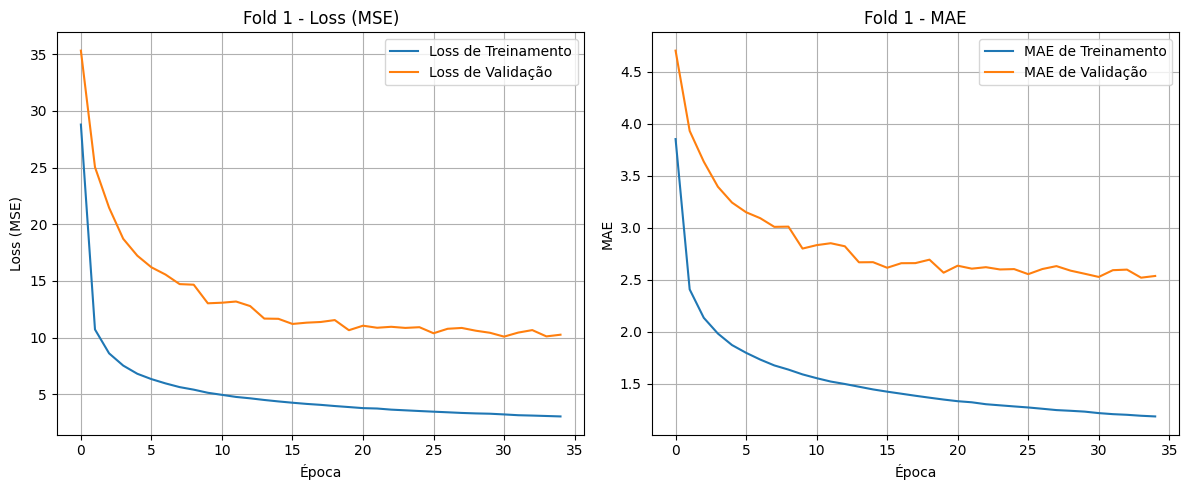


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 10.0781, MAE: 2.5259

--- Iniciando Fold 2/2 ---
Epoch 1/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - loss: 68.2529 - mae: 6.3024 - val_loss: 34.5039 - val_mae: 4.6772 - learning_rate: 1.0000e-06
Epoch 2/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 14.8647 - mae: 2.8900 - val_loss: 22.1279 - val_mae: 3.7246 - learning_rate: 1.0000e-06
Epoch 3/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 11.5343 - mae: 2.5144 - val_loss: 16.0096 - val_mae: 3.1180 - learning_rate: 1.0000e-06
Epoch 4/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 9.9371 - mae: 2.3147 - val_loss: 13.0703 - val_mae: 2.7813 - learning_rate: 1.0000e-06
Epoch 5/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 8.8798 - mae: 2.1692 - val_loss: 11.4863 - val_mae: 2.5799 - learning_rate: 1.0000e-06
Epoch 6/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 8.1551 - mae: 2.0647 - val_loss: 10.7711 - val_mae: 2.5046 - learning_

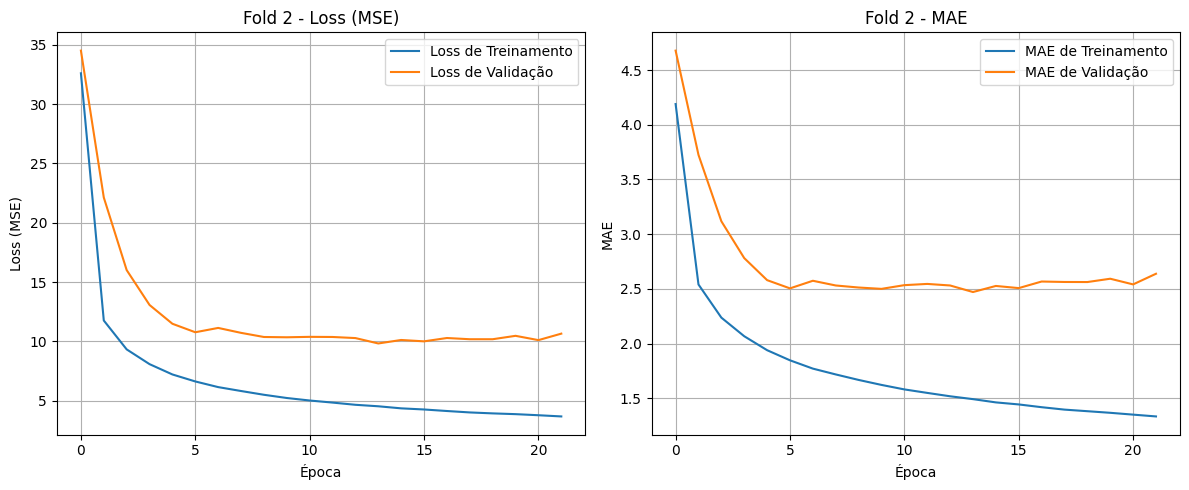


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 9.8270, MAE: 2.4712

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 10.0781, MAE = 2.5259
Fold 2: Loss (MSE) = 9.8270, MAE = 2.4712

Média de MAE de Validação nos 2 Folds: 2.4986
Média de Loss (MSE) de Validação nos 2 Folds: 9.9525

Testando Combinação: Learning Rate = 1e-06, Batch Size = 256

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - loss: 113.4790 - mae: 8.3147 - val_loss: 43.0514 - val_mae: 5.3117 - learning_rate: 1.0000e-06
Epoch 2/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 20.6360 - mae: 3.4767 - val_loss: 33.7177 - val_mae: 4.5237 - learning_rate: 1.0000e-06
Epoch 3/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 17.1755 - mae: 3.0958 - val_loss: 28.3967 - val_mae: 4.1249 - learning_rate: 1.0000e-06
Epoch 4/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 15.0292 - mae: 2.8640 - val_

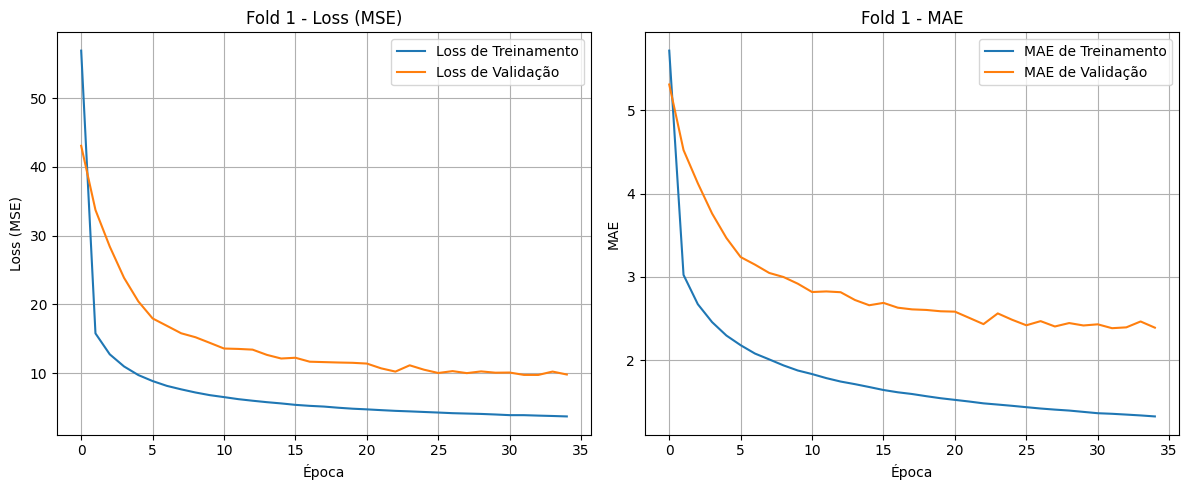


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 9.7211, MAE: 2.3930

--- Iniciando Fold 2/2 ---
Epoch 1/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - loss: 95.5936 - mae: 7.6956 - val_loss: 39.2457 - val_mae: 5.1560 - learning_rate: 1.0000e-06
Epoch 2/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 18.8471 - mae: 3.3032 - val_loss: 28.8982 - val_mae: 4.3468 - learning_rate: 1.0000e-06
Epoch 3/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 14.7867 - mae: 2.8871 - val_loss: 22.1522 - val_mae: 3.7782 - learning_rate: 1.0000e-06
Epoch 4/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 12.5199 - mae: 2.6262 - val_loss: 18.8551 - val_mae: 3.4842 - learning_rate: 1.0000e-06
Epoch 5/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 11.0517 - mae: 2.4564 - val_loss: 16.1676 - val_mae: 3.1976 - learning_rate: 1.0000e-06
Epoch 6/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 9.9969 - mae: 2.3209 - val_loss: 15.2945 - val_mae: 3.1155 - learning_rate: 1.000

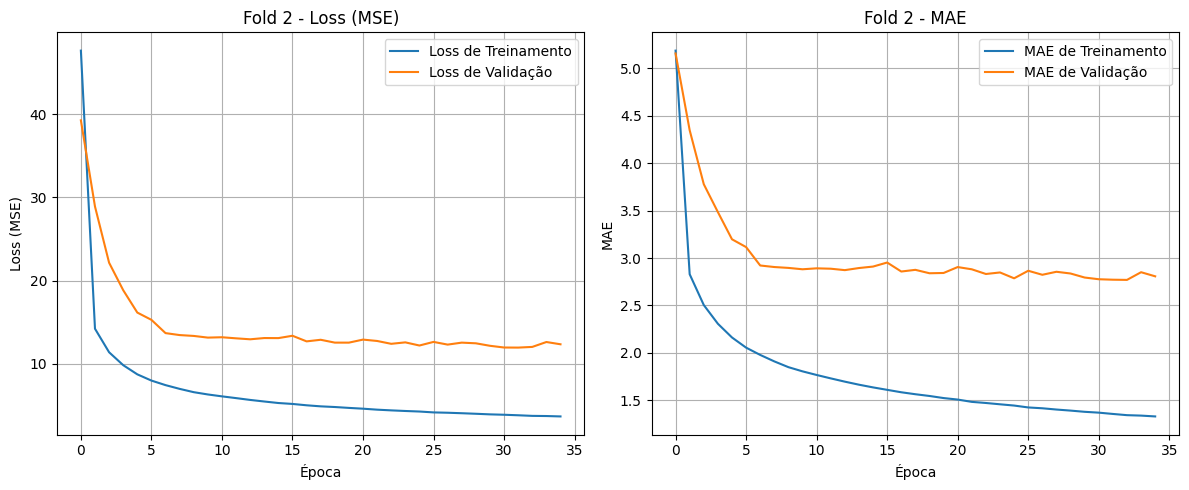


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 11.9629, MAE: 2.7717

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 9.7211, MAE = 2.3930
Fold 2: Loss (MSE) = 11.9629, MAE = 2.7717

Média de MAE de Validação nos 2 Folds: 2.5823
Média de Loss (MSE) de Validação nos 2 Folds: 10.8420

Testando Combinação: Learning Rate = 1e-05, Batch Size = 128

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 24.2403 - mae: 3.2194 - val_loss: 21.3644 - val_mae: 3.5650 - learning_rate: 1.0000e-05
Epoch 2/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 7.2262 - mae: 1.8867 - val_loss: 23.0705 - val_mae: 3.8269 - learning_rate: 1.0000e-05
Epoch 3/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 6.4418 - mae: 1.7453 - val_loss: 19.9783 - val_mae: 3.5396 - learning_rate: 1.0000e-05
Epoch 4/35
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 5.3197 - mae: 1.5768 

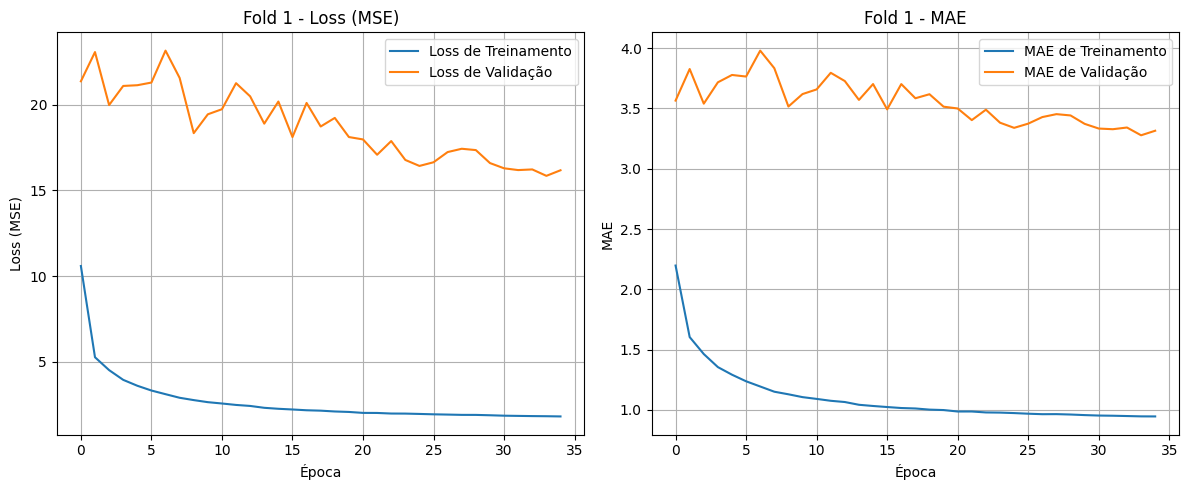


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 15.8489, MAE: 3.2774

--- Iniciando Fold 2/2 ---
Epoch 1/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - loss: 21.6854 - mae: 3.1087 - val_loss: 16.6565 - val_mae: 3.2087 - learning_rate: 1.0000e-05
Epoch 2/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 7.2160 - mae: 1.8960 - val_loss: 16.6483 - val_mae: 3.2145 - learning_rate: 1.0000e-05
Epoch 3/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 6.0937 - mae: 1.7226 - val_loss: 18.2205 - val_mae: 3.4232 - learning_rate: 1.0000e-05
Epoch 4/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 5.1431 - mae: 1.5696 - val_loss: 21.2698 - val_mae: 3.7667 - learning_rate: 1.0000e-05
Epoch 5/35
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 4.6755 - mae: 1.4888 - val_loss: 19.5758 - val_mae: 3.5991 - learning_rate: 1.0000e-05
Epoch 6/35
1375/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2191 - mae: 1.4048
Epoch 6: ReduceLROnPlateau reducing learning rate to

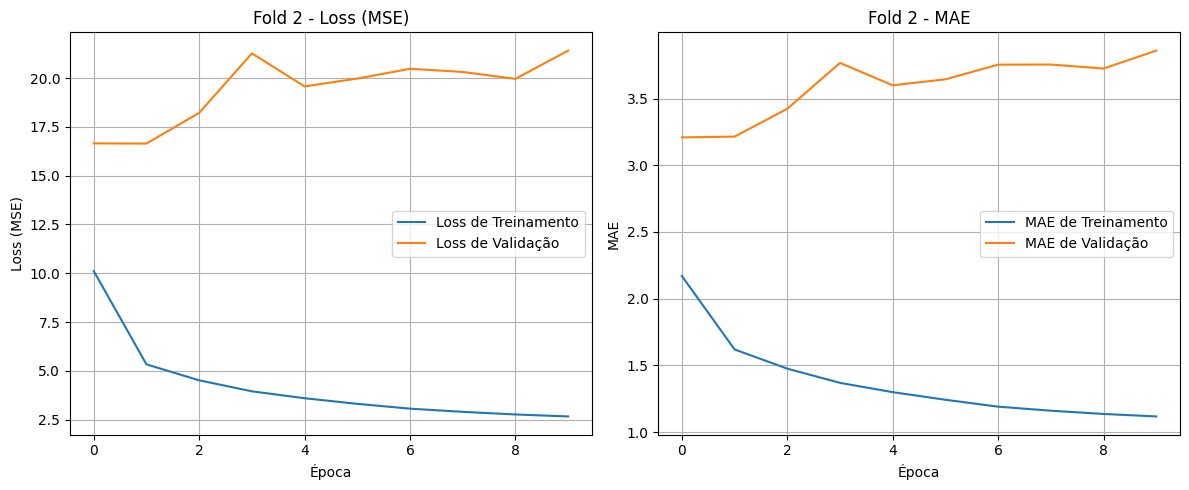


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 16.6483, MAE: 3.2145

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 15.8489, MAE = 3.2774
Fold 2: Loss (MSE) = 16.6483, MAE = 3.2145

Média de MAE de Validação nos 2 Folds: 3.2459
Média de Loss (MSE) de Validação nos 2 Folds: 16.2486

Testando Combinação: Learning Rate = 1e-05, Batch Size = 256

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - loss: 33.0568 - mae: 3.8572 - val_loss: 22.9788 - val_mae: 3.7278 - learning_rate: 1.0000e-05
Epoch 2/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 10.0658 - mae: 2.2603 - val_loss: 20.5676 - val_mae: 3.4728 - learning_rate: 1.0000e-05
Epoch 3/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 8.3132 - mae: 2.0293 - val_loss: 20.2667 - val_mae: 3.4561 - learning_rate: 1.0000e-05
Epoch 4/35
677/677 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 7.5886 - mae: 1.9227 - val_

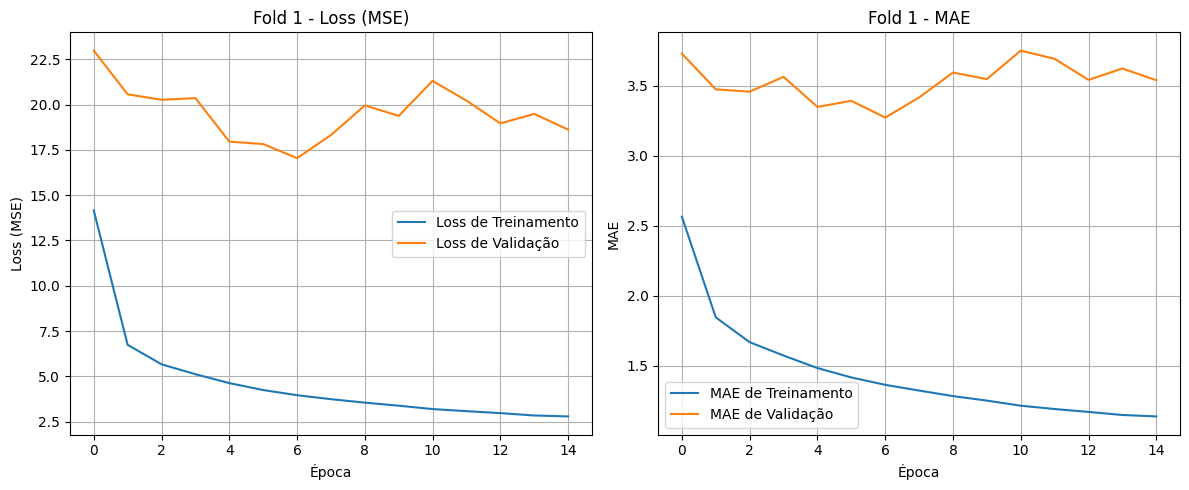


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 17.0427, MAE: 3.2715

--- Iniciando Fold 2/2 ---
Epoch 1/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - loss: 31.5653 - mae: 3.8340 - val_loss: 17.2465 - val_mae: 3.2969 - learning_rate: 1.0000e-05
Epoch 2/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 9.0728 - mae: 2.1711 - val_loss: 12.3245 - val_mae: 2.6512 - learning_rate: 1.0000e-05
Epoch 3/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 7.4847 - mae: 1.9476 - val_loss: 13.5566 - val_mae: 2.8458 - learning_rate: 1.0000e-05
Epoch 4/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 6.8370 - mae: 1.8431 - val_loss: 13.7751 - val_mae: 2.9418 - learning_rate: 1.0000e-05
Epoch 5/35
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 5.9498 - mae: 1.7061 - val_loss: 13.6973 - val_mae: 2.9742 - learning_rate: 1.0000e-05
Epoch 6/35
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.4210 - mae: 1.6268
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873

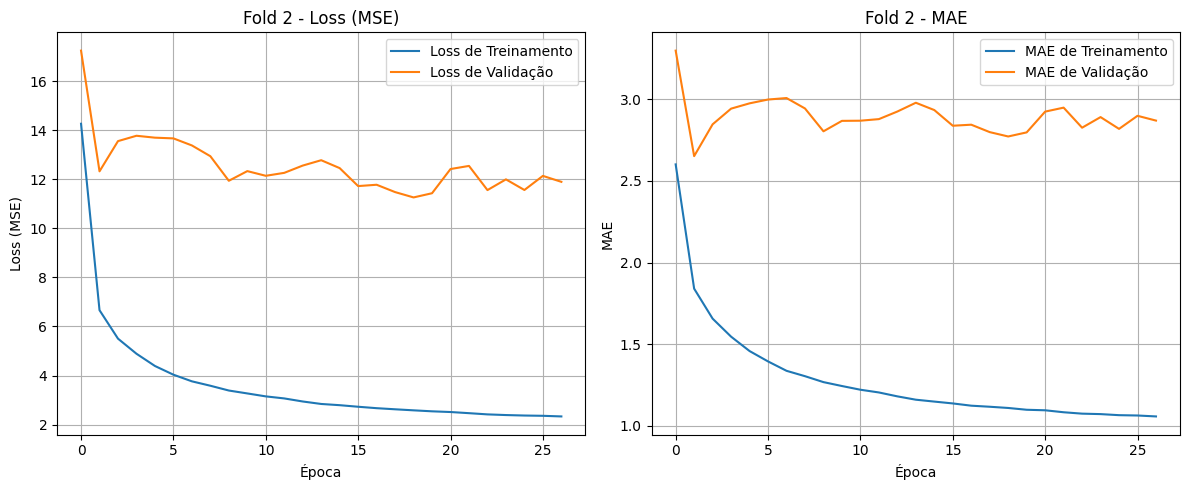


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 11.2608, MAE: 2.7714

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 17.0427, MAE = 3.2715
Fold 2: Loss (MSE) = 11.2608, MAE = 2.7714

Média de MAE de Validação nos 2 Folds: 3.0215
Média de Loss (MSE) de Validação nos 2 Folds: 14.1517

Resultados Finais do Grid Search de Hiperparâmetros
Melhor combinação de hiperparâmetros encontrada:
  Learning Rate: 1e-06
  Batch Size: 128
  Média de MAE de Validação: 2.4986

Todos os resultados médios de MAE de validação por combinação:
  LR: 1e-06, BS: 128 -> Média MAE: 2.4986
  LR: 1e-06, BS: 256 -> Média MAE: 2.5823
  LR: 1e-05, BS: 128 -> Média MAE: 3.2459
  LR: 1e-05, BS: 256 -> Média MAE: 3.0215


In [22]:
grid_search(
    learning_rates_to_test=learning_rates_to_test,
    batch_sizes_to_test=batch_sizes_to_test,
    unique_dates=unique_dates_trainval,
    date_to_indices=date_to_indices_trainval,
    pv_np=trainval_pv_np,
    images_np=trainval_images_np,
    num_epochs=num_epochs,
    k_splits=k_splits,
    reduce_lr_patience=reduce_lr_patience, 
    earlystop_patience=earlystop_patience
)

Analisando os resultados acima, podemos ver que a para os batch sizes 128 e 256 taxas menores que 1e-5 são mais interessantes, tendo em vista o desemepenho ruim durante as combinações com uma taxa de aprendizado de 1e-5. Logo, para esses batch sizes, não faz muito sentido testar taxas maiores que 1e-5. 

A configruação ótima parece já ter sido atingida, mas para confirmar a intuição e obter mais informações sobre o desempenho do modelo para diferentes combinações de hiperparâmetros, vamos testar agora batch sizes menores em conjunto com taxas maiores que 1e-5. 

In [19]:
# Parâmetros para Otimização (Grid Search)
learning_rates_to_test = [1e-3, 1e-4] 
batch_sizes_to_test = [32, 64]
num_epochs = 35
k_splits = 2 # Número reduzido de splits apenas para experimentação inicial

reduce_lr_patience = 4
earlystop_patience = 8


Iniciando o Grid Search de Hiperparâmetros com 2-Fold Cross-Validation...

Testando Combinação: Learning Rate = 0.001, Batch Size = 32

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35


I0000 00:00:1750706961.110976      96 service.cc:148] XLA service 0x7bc7ac00ff30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750706961.111808      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750706961.479403      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  29/5409 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1376.9713 - mae: 21.4005

I0000 00:00:1750706964.339683      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5409/5409 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 30.2895 - mae: 2.4619 - val_loss: 70.3186 - val_mae: 7.0493 - learning_rate: 0.0010
Epoch 2/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 6.8794 - mae: 1.8097 - val_loss: 65.8969 - val_mae: 6.8315 - learning_rate: 0.0010
Epoch 3/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 6.2481 - mae: 1.7138 - val_loss: 40.5893 - val_mae: 5.3731 - learning_rate: 0.0010
Epoch 4/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 5.4483 - mae: 1.6107 - val_loss: 55.8553 - val_mae: 6.2863 - learning_rate: 0.0010
Epoch 5/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 5.3881 - mae: 1.5668 - val_loss: 45.1562 - val_mae: 5.6150 - learning_rate: 0.0010
Epoch 6/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 5.0159 - mae: 1.5143 - val_loss: 47.6501 - val_mae: 5.7965 - learning_rate: 0.0010
Epoch 7/35
5401/5409 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6874 - mae: 1.4601
Epoch 7: ReduceLROnPlateau reducing learning rate t

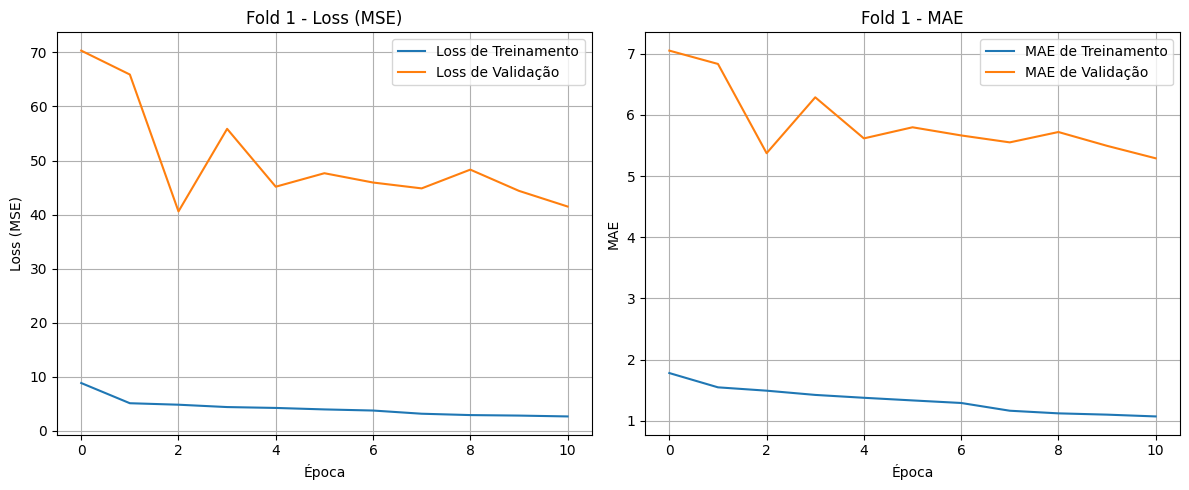


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 40.5893, MAE: 5.3731

--- Iniciando Fold 2/2 ---
Epoch 1/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 23.3835 - mae: 2.4477 - val_loss: 75.5653 - val_mae: 7.3818 - learning_rate: 0.0010
Epoch 2/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 6.5317 - mae: 1.7935 - val_loss: 57.2272 - val_mae: 6.4237 - learning_rate: 0.0010
Epoch 3/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 5.8939 - mae: 1.7074 - val_loss: 55.2270 - val_mae: 6.1486 - learning_rate: 0.0010
Epoch 4/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 5.1093 - mae: 1.5699 - val_loss: 59.8009 - val_mae: 6.2289 - learning_rate: 0.0010
Epoch 5/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 4.7134 - mae: 1.4921 - val_loss: 51.9341 - val_mae: 6.0093 - learning_rate: 0.0010
Epoch 6/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 4.6408 - mae: 1.4570 - val_loss: 46.1091 - val_mae: 5.6501 - learning_rate: 0.0010
Epoch 7/35
5510

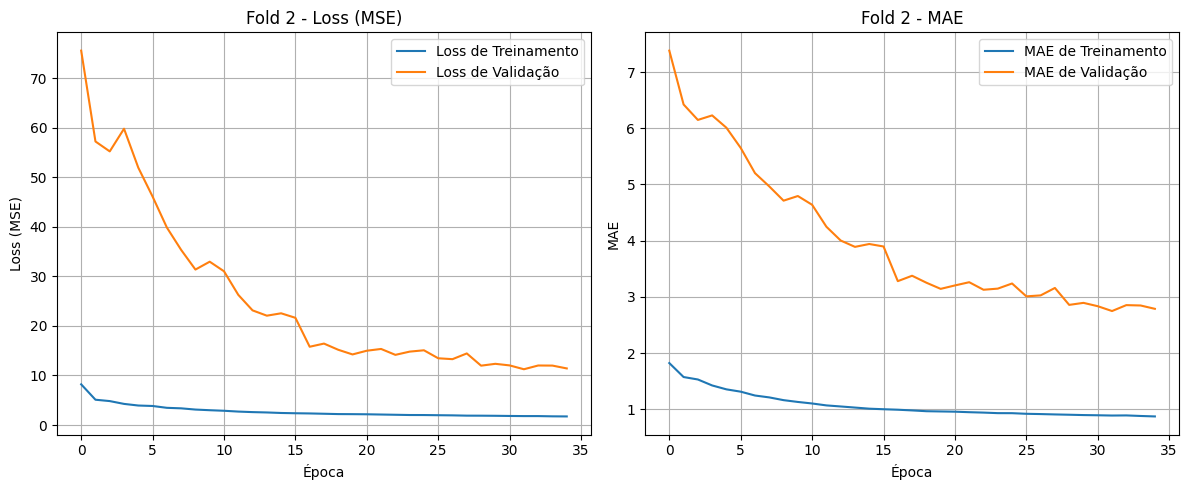


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 11.2566, MAE: 2.7476

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 40.5893, MAE = 5.3731
Fold 2: Loss (MSE) = 11.2566, MAE = 2.7476

Média de MAE de Validação nos 2 Folds: 4.0603
Média de Loss (MSE) de Validação nos 2 Folds: 25.9229

Testando Combinação: Learning Rate = 0.001, Batch Size = 64

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 51.8440 - mae: 2.7272 - val_loss: 77.5076 - val_mae: 7.4526 - learning_rate: 0.0010
Epoch 2/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 6.5141 - mae: 1.7578 - val_loss: 66.9698 - val_mae: 6.9215 - learning_rate: 0.0010
Epoch 3/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 5.6075 - mae: 1.6474 - val_loss: 47.6686 - val_mae: 5.8023 - learning_rate: 0.0010
Epoch 4/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 5.3167 - mae: 1.5896 - val_loss: 

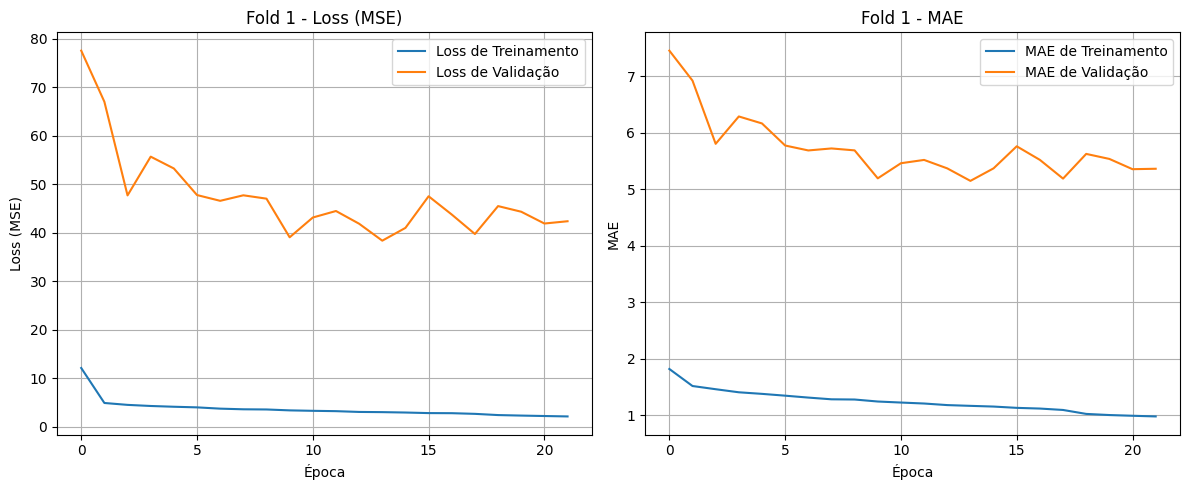


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 38.3373, MAE: 5.1461

--- Iniciando Fold 2/2 ---
Epoch 1/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 63.1294 - mae: 2.8501 - val_loss: 56.8053 - val_mae: 6.3653 - learning_rate: 0.0010
Epoch 2/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 6.7172 - mae: 1.7943 - val_loss: 66.2071 - val_mae: 6.8029 - learning_rate: 0.0010
Epoch 3/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 6.4605 - mae: 1.7624 - val_loss: 48.5045 - val_mae: 5.8409 - learning_rate: 0.0010
Epoch 4/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 5.6433 - mae: 1.6515 - val_loss: 60.6924 - val_mae: 6.5601 - learning_rate: 0.0010
Epoch 5/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 5.5011 - mae: 1.6012 - val_loss: 47.1640 - val_mae: 5.7755 - learning_rate: 0.0010
Epoch 6/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 4.8753 - mae: 1.5114 - val_loss: 48.9196 - val_mae: 5.9020 - learning_rate: 0.0010
Epoch 7/3

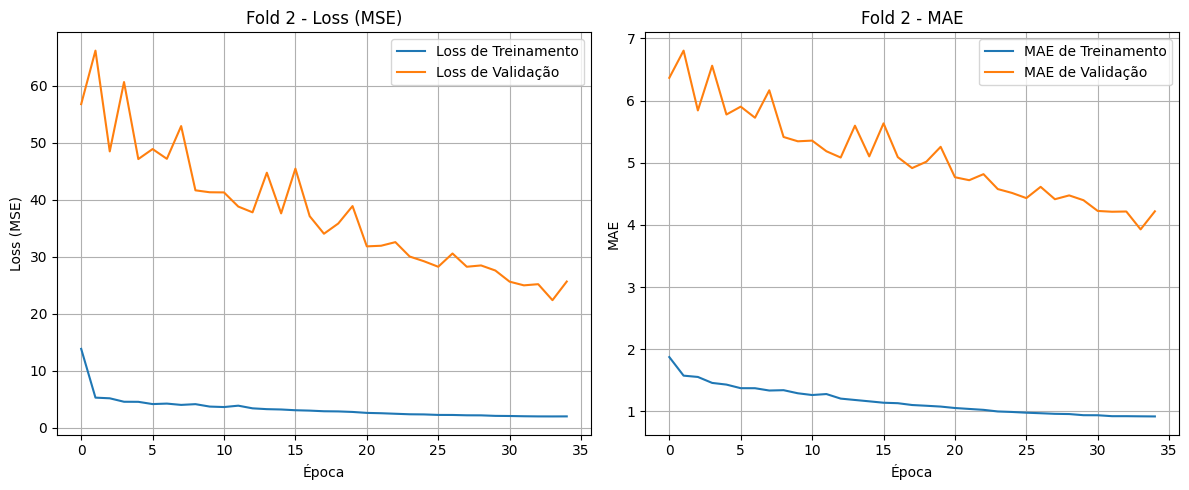


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 22.3846, MAE: 3.9280

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 38.3373, MAE = 5.1461
Fold 2: Loss (MSE) = 22.3846, MAE = 3.9280

Média de MAE de Validação nos 2 Folds: 4.5371
Média de Loss (MSE) de Validação nos 2 Folds: 30.3609

Testando Combinação: Learning Rate = 0.0001, Batch Size = 32

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 9.0148 - mae: 2.0432 - val_loss: 76.5216 - val_mae: 7.4599 - learning_rate: 1.0000e-04
Epoch 2/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 4.9083 - mae: 1.4945 - val_loss: 52.1027 - val_mae: 6.0246 - learning_rate: 1.0000e-04
Epoch 3/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 4.0063 - mae: 1.3507 - val_loss: 68.6602 - val_mae: 7.0018 - learning_rate: 1.0000e-04
Epoch 4/35
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 3.5479 - mae: 1.2708 - va

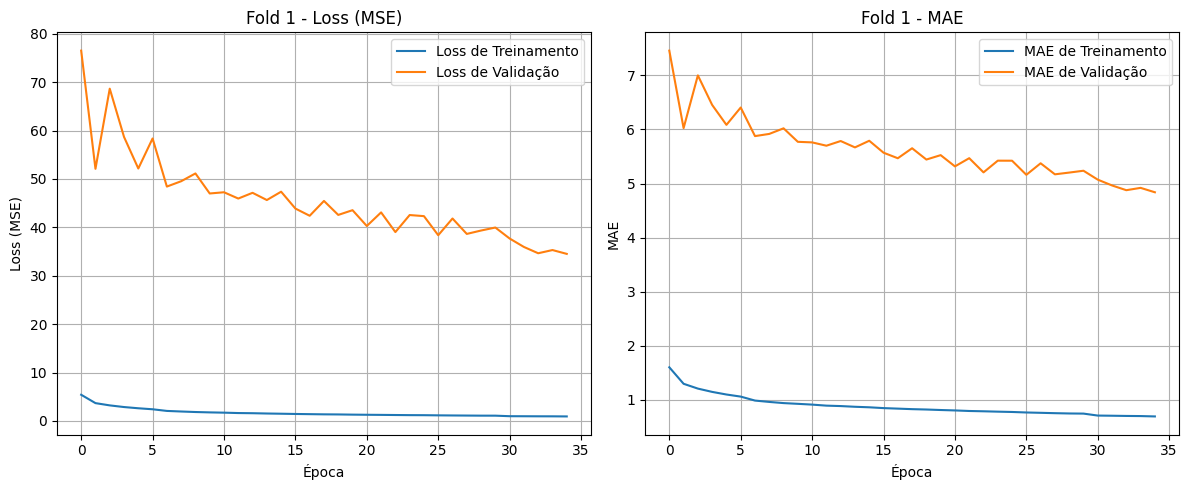


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 34.5263, MAE: 4.8379

--- Iniciando Fold 2/2 ---
Epoch 1/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 8.5718 - mae: 2.0325 - val_loss: 52.5424 - val_mae: 6.1926 - learning_rate: 1.0000e-04
Epoch 2/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 4.5223 - mae: 1.4570 - val_loss: 64.6298 - val_mae: 6.8824 - learning_rate: 1.0000e-04
Epoch 3/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 3.7539 - mae: 1.3165 - val_loss: 58.1576 - val_mae: 6.4872 - learning_rate: 1.0000e-04
Epoch 4/35
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 3.2507 - mae: 1.2275 - val_loss: 59.0163 - val_mae: 6.5050 - learning_rate: 1.0000e-04
Epoch 5/35
5507/5510 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9305 - mae: 1.1728
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
5510/5510 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 2.9302 - mae: 1.1728 - val_loss: 56.4689 - val_mae: 6.3802 - learning_rate: 1.000

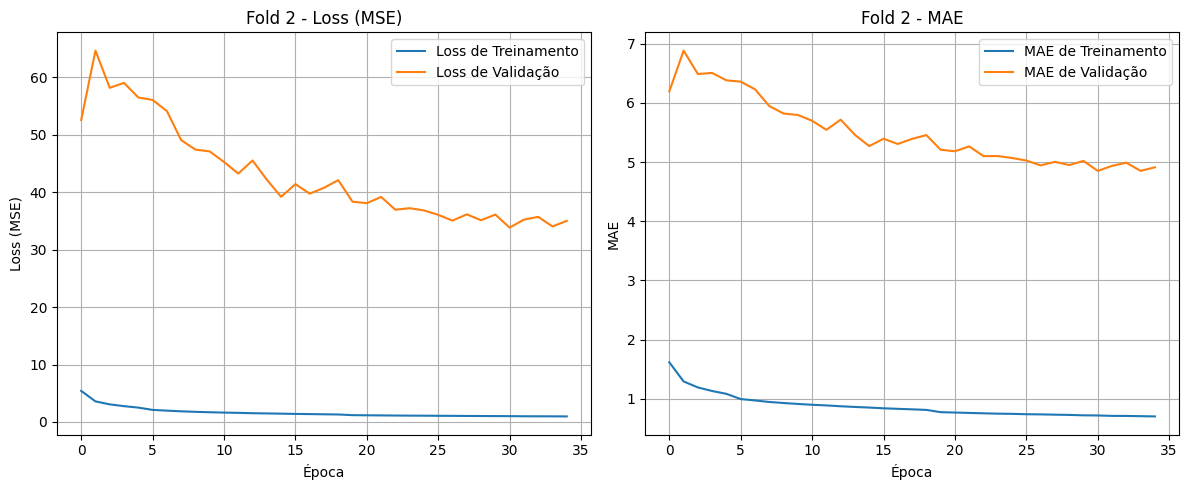


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 33.8281, MAE: 4.8495

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 34.5263, MAE = 4.8379
Fold 2: Loss (MSE) = 33.8281, MAE = 4.8495

Média de MAE de Validação nos 2 Folds: 4.8437
Média de Loss (MSE) de Validação nos 2 Folds: 34.1772

Testando Combinação: Learning Rate = 0.0001, Batch Size = 64

Iniciando treinamento com 2-Fold Cross-Validation (por dia)...

--- Iniciando Fold 1/2 ---
Epoch 1/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 10.3396 - mae: 2.1368 - val_loss: 45.0925 - val_mae: 5.6249 - learning_rate: 1.0000e-04
Epoch 2/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 5.0645 - mae: 1.5455 - val_loss: 53.3042 - val_mae: 6.1894 - learning_rate: 1.0000e-04
Epoch 3/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 4.3029 - mae: 1.4115 - val_loss: 56.9333 - val_mae: 6.4356 - learning_rate: 1.0000e-04
Epoch 4/35
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 3.6701 - mae: 1.3062

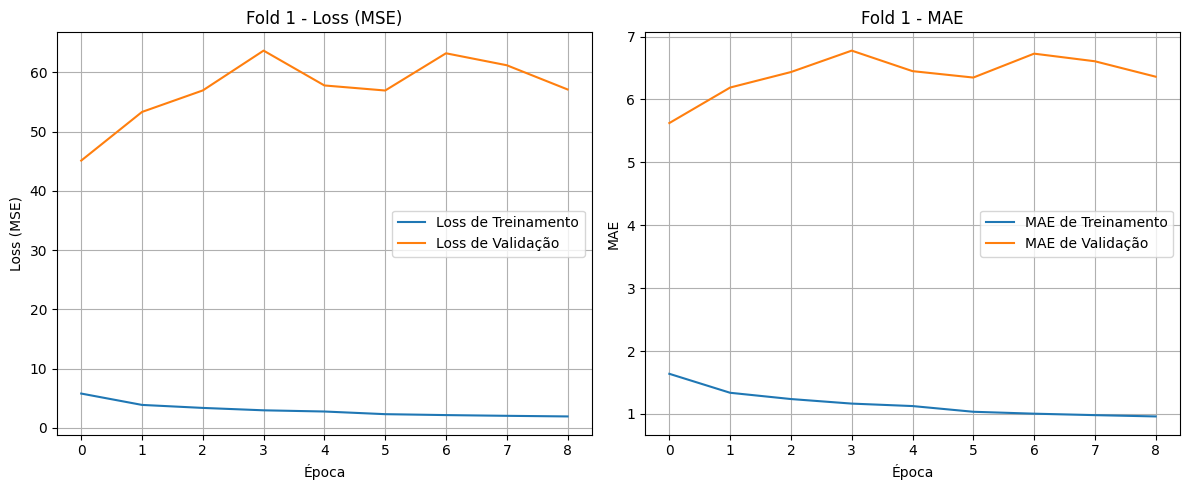


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 45.0925, MAE: 5.6249

--- Iniciando Fold 2/2 ---
Epoch 1/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 9.7340 - mae: 2.1191 - val_loss: 57.3886 - val_mae: 6.4117 - learning_rate: 1.0000e-04
Epoch 2/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 4.7949 - mae: 1.4968 - val_loss: 58.8951 - val_mae: 6.5795 - learning_rate: 1.0000e-04
Epoch 3/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 3.9098 - mae: 1.3466 - val_loss: 56.4963 - val_mae: 6.3922 - learning_rate: 1.0000e-04
Epoch 4/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 3.3570 - mae: 1.2559 - val_loss: 60.3100 - val_mae: 6.6477 - learning_rate: 1.0000e-04
Epoch 5/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 3.0805 - mae: 1.2110 - val_loss: 52.1889 - val_mae: 6.1383 - learning_rate: 1.0000e-04
Epoch 6/35
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 2.7099 - mae: 1.1378 - val_loss: 54.5813 - val_mae: 6.2791 - learning_rat

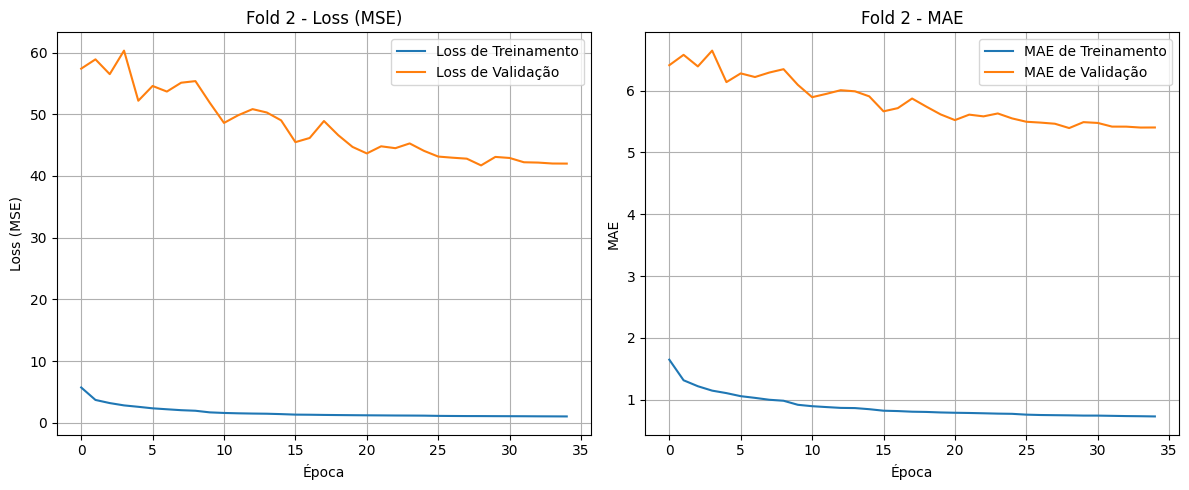


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 41.7097, MAE: 5.3945

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 45.0925, MAE = 5.6249
Fold 2: Loss (MSE) = 41.7097, MAE = 5.3945

Média de MAE de Validação nos 2 Folds: 5.5097
Média de Loss (MSE) de Validação nos 2 Folds: 43.4011

Resultados Finais do Grid Search de Hiperparâmetros
Melhor combinação de hiperparâmetros encontrada:
  Learning Rate: 0.001
  Batch Size: 32
  Média de MAE de Validação: 4.0603

Todos os resultados médios de MAE de validação por combinação:
  LR: 0.001, BS: 32 -> Média MAE: 4.0603
  LR: 0.001, BS: 64 -> Média MAE: 4.5371
  LR: 0.0001, BS: 32 -> Média MAE: 4.8437
  LR: 0.0001, BS: 64 -> Média MAE: 5.5097


In [20]:
grid_search(
    learning_rates_to_test=learning_rates_to_test,
    batch_sizes_to_test=batch_sizes_to_test,
    unique_dates=unique_dates_trainval,
    date_to_indices=date_to_indices_trainval,
    pv_np=trainval_pv_np,
    images_np=trainval_images_np,
    num_epochs=num_epochs,
    k_splits=k_splits,
    reduce_lr_patience=reduce_lr_patience, 
    earlystop_patience=earlystop_patience
)

A partir dos resultados abaixo é possível observar que desempenho do modelo oscila mais com um batch_size menor, o que é esperado devido à natureza estocástica do treinamento, que acaba se manifestando mais ainda com batch sizes menores. Cada mini-batch é um pouco diferente, e isso introduz uma variância natural nos gradientes e nas atualizações de peso do modelo. Além disso, as taxas mais altas contribuem também para essa oscilação.

**Resumo dos resultados do Grid Search:**

1. LR:  1e-06,  BS: 128 -> Média MAE: 2.4986
2. LR:  1e-06,  BS: 256 -> Média MAE: 2.5823
3. LR:  1e-05,  BS: 128 -> Média MAE: 3.2459
4. LR:  1e-05,  BS: 256 -> Média MAE: 3.0215
5. LR:  0.001,   BS: 32 -> Média MAE: 4.0603
6. LR:  0.001,   BS: 64 -> Média MAE: 4.5371
7. LR: 0.0001,   BS: 32 -> Média MAE: 4.8437
8. LR: 0.0001,   BS: 64 -> Média MAE: 5.5097

A paritr dos resultados anteriores fica difícil concluir qual batch size é melhor: 128 ou 256. Para uma taxa de 1e-6 não tem muita diferença entre os dois tamanhos. Em contrapartida, fica claro que taxas maiores apresentam um desempenho inferior. Esse era o objetivo do grid search: descartar combinações claramente inferiores.

Contudo, devido à alta variância do desempenho dos modelos, o que é natural devido à natureza estocástica do treinamento, não podemos afirmar qual é a melhor combinação entre taxa de aprendizado e batch size. Especificamente, não há muita diferença entre os batch sizes 256 e 128. Portanto, de forma a dar continuidade ao desenvolvimento, será escolhida como combinação ótima a que apresentou melhor desempenho empiricamente.

### Testando shuffle nos índices

A partir de agora, iremos utilizar uma adaptação da função create_dataset. Agora, ela faz o shuffle em um dataset de índices ao invés no dataset com as imagens e valores PV. Assim, podemos fazer um embaralhamento completo no conjunto de treinamento sem estourar a memória RAM do Kaggle. Espera-se obter resultados superiores.

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import time
import random
import datetime
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-06-30 20:59:35.338902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751317175.525082      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751317175.580310      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_folder = "/kaggle/input/skippd"
data_path = os.path.join(data_folder, "2017_2019_images_pv_processed.hdf5")
times_trainval_path = os.path.join(data_folder, "times_trainval.npy")
times_test_path = os.path.join(data_folder, "times_test.npy")


print("data_folder:", data_folder)
print("data_path:", data_path)
print("times_trainval_path:", times_trainval_path)
print("times_test_path:", times_test_path)

skippd_dataset = h5py.File(data_path, 'r')

data_folder: /kaggle/input/skippd
data_path: /kaggle/input/skippd/2017_2019_images_pv_processed.hdf5
times_trainval_path: /kaggle/input/skippd/times_trainval.npy
times_test_path: /kaggle/input/skippd/times_test.npy


In [3]:
# get the input dimension for constructing the model
img_side_len = skippd_dataset['trainval']['images_log'].shape[1]
num_color_channel = skippd_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define the model architecture using tf.keras API
def sunset_model():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = keras.Input(shape=image_input_dim)

    ## 1st convolution block
    x = keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## two fully connected nets
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model
    model = keras.Model(inputs=x_in,outputs=y_out)

    return model

In [4]:
def create_dataset(is_test, batch_size, sample_indices_np, hdf5_data_path_str):
    """
    Cria uma pipeline de dados tf.data com embaralhamento completo de índices e carregamento de imagens e valores PV do arquivo HDF5.

    Args:
    - is_test (bool): True se for um conjunto de teste/validação (sem shuffle), False para treino (com shuffle).
    - batch_size (int): O tamanho do lote de dados.
    - sample_indices_np (np.array): Array NumPy contendo os índices das amostras (ex: fold_train_sample_indices ou fold_val_sample_indices).
    - hdf5_data_path_str (str): O caminho para o arquivo .hdf5.
    """
    hdf5_data_path_tensor = tf.constant(hdf5_data_path_str, dtype=tf.string)
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_indices_np)
    
    if not is_test: # Para teste/validação não se faz shuffle 
        idx_ds = idx_ds.shuffle(buffer_size=len(sample_indices_np), reshuffle_each_iteration=True) # Shuffle ANTES do batch
    idx_ds = idx_ds.batch(batch_size) 

    def load_batch_data(sample_indices_batch_tf): # Função que será mapeada em cima de idx_ds    
        
        def _load_batch_data_np(indices_batch, data_path_decoded_tensor): # Função que interage diretamente com o arquivo HDF5
            indices_np = indices_batch.numpy() 
            data_path_decoded_str = data_path_decoded_tensor.numpy().decode('utf-8')
            sorted_indices_np = sorted(indices_np) # Ordenar índices do lote antes de ler o HDF5. Ler arquivos de forma ordenada é mais rápido que ler os índices do batch que estão aleatorizados. 

            with h5py.File(data_path_decoded_str, 'r') as f: 
                images = f['/trainval/images_log'][sorted_indices_np]
                pvs = f['/trainval/pv_log'][sorted_indices_np]

                images = tf.image.convert_image_dtype(images, tf.float32).numpy() # Converte para NumPy para retornar via py_function
                pvs = tf.cast(pvs, tf.float32).numpy()
            
            return images, pvs

        images_batch_tensor, pvs_batch_tensor = tf.py_function(func=_load_batch_data_np, inp=[sample_indices_batch_tf, hdf5_data_path_tensor],Tout=(tf.float32, tf.float32))
        images_batch_tensor.set_shape([None, img_side_len, img_side_len, num_color_channel]) # None na primeira dimensão indica um tamanho de lote flexível (o último lote de um dataset pode ser menor que batch_size).
        pvs_batch_tensor.set_shape([None])

        return images_batch_tensor, pvs_batch_tensor

    
    dataset = idx_ds.map(load_batch_data, num_parallel_calls=tf.data.AUTOTUNE) # Ao ser chamda com map, a função é aplicada a cada batch de índices de idx_ds.
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [5]:
def plot_training_history(history, fold_name="", lr=None, bs=None):
    """
    Plota histórico de treinamento.
    """
    plt.figure(figsize=(12, 5))

    title_suffix = ""
    if lr is not None: title_suffix += f" LR={lr}"
    if bs is not None: title_suffix += f" BS={bs}"

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Loss de Treinamento')
    if 'val_loss' in history: plt.plot(history['val_loss'], label='Loss de Validação')
    plt.title(f'{fold_name} - Loss (MSE){title_suffix}')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.show()

In [6]:
def cv_split(unique_dates, date_to_indices, train_indices, val_indices):
    """
     Função que retorna os índices de treinamento e validação para cada fold.
     A função deve ser chamada a cada fold.
     
     - unique_dates: array contendo as datas únicas presentes no conjunto.
     - date_to_indices: dicionário contendo que agrupa os índices do conjunto por data.
     - train_indices e val_indices: índices de cada fold fornecidos pelo kf.split, onde o split é feito no array unique_dates.
     - pv_np e images_np: arrays np carregados do arquivo hdf5.
     """

    # Obter as datas reais para o fold
    train_dates = [unique_dates[i] for i in train_indices]
    val_dates = [unique_dates[i] for i in val_indices]
    
    # Obter os índices reais das amostras para o fold
    train_real_indices = np.concatenate([date_to_indices[d] for d in train_dates])
    val_real_indices = np.concatenate([date_to_indices[d] for d in val_dates])
    
    return train_real_indices, val_real_indices

In [11]:
def cross_val(unique_dates, date_to_indices, learning_rate, batch_size,
              reduce_lr_patience, earlystop_patience, num_epochs, k_splits, models_dir='submodels'):
    """
    Função de validação cruzada adaptada para salvar cada submodelo treinado em um diretório.
    """
    # Cria um diretório para salvar os modelos, se não existir
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
    fold_histories = []
    fold_eval_results = []
    saved_model_paths = [] # Lista para guardar os caminhos dos modelos salvos

    print(f"\nIniciando treinamento com {k_splits}-Fold Cross-Validation...")

    for fold_idx, (train_date_indices, val_date_indices) in enumerate(kf.split(unique_dates)):
        print(f"\n--- Iniciando Fold {fold_idx + 1}/{k_splits} ---")
        keras.backend.clear_session()

        fold_train_indices, fold_val_indices = cv_split(unique_dates, date_to_indices, train_date_indices, val_date_indices)
        
        train_dataset_fold = create_dataset(is_test=False, batch_size=batch_size, sample_indices_np=fold_train_indices, hdf5_data_path_str=data_path)
        val_dataset_fold = create_dataset(is_test=True, batch_size=batch_size, sample_indices_np=fold_val_indices, hdf5_data_path_str=data_path)
    
        model = sunset_model()
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
    
        earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_patience, min_lr=1e-8, verbose=1)
    
        history = model.fit(train_dataset_fold, epochs=num_epochs, validation_data=val_dataset_fold, callbacks=[earlystop, reduce_lr], verbose=1)
        fold_histories.append(history.history)
        
        plot_training_history(history.history, fold_name=f"Fold {fold_idx + 1}")
    
        print(f"\nAvaliação do Fold {fold_idx + 1} no conjunto de validação:")
        val_loss = model.evaluate(val_dataset_fold, verbose=0)
        print(f"Loss (MSE): {val_loss:.4f}")
        fold_eval_results.append({'loss': val_loss})

        # Salvando submodelo atual
        model_path = os.path.join(models_dir, f'submodel_fold_{fold_idx + 1}.keras')
        print(f"Salvando modelo do fold {fold_idx + 1} em: {model_path}")
        model.save(model_path)
        saved_model_paths.append(model_path)


    print("\n--- Resumo dos Resultados do K-Fold ---")
    for i, results in enumerate(fold_eval_results):
        print(f"Fold {i + 1}: Loss (MSE) = {results['loss']:.4f}")
    
    avg_loss = np.mean([r['loss'] for r in fold_eval_results])
    print(f"Média da Loss (MSE) de Validação nos {k_splits} Folds: {avg_loss:.4f}")
    
    return avg_loss, fold_histories, saved_model_paths

In [12]:
def plot_average_validation_curve(histories, metric='val_loss'):
    """
    Plota a curva de desempenho médio de validação entre todos os folds,
    com uma região sombreada representando o desvio padrão.

    Args:
        histories (list[dict]): Uma lista contendo os dicionários de histórico
            (history.history) de cada fold.
        metric (str): A métrica de validação a ser plotada (ex: 'val_loss',
            'val_root_mean_squared_error').
    """
    # Extrair a métrica de validação de cada histórico de fold
    val_curves = [h[metric] for h in histories if metric in h]
    if not val_curves:
        print(f"Métrica '{metric}' não encontrada nos históricos.")
        return

    # Lidar com comprimentos de épocas diferentes (devido ao EarlyStopping)
    max_epochs = max(len(curve) for curve in val_curves) # Encontra o número máximo de épocas em qualquer um dos folds

    # Cria um array 2D preenchido com NaN (Not a Number)
    # Dimensões: (número de folds) x (número máximo de épocas)
    padded_curves = np.full((len(val_curves), max_epochs), np.nan)

    # Preenche o array com os dados de cada curva
    for i, curve in enumerate(val_curves):
        padded_curves[i, :len(curve)] = curve

    # Calcular a média e o desvio padrão em cada época, ignorando os NaNs
    mean_curve = np.nanmean(padded_curves, axis=0)
    std_curve = np.nanstd(padded_curves, axis=0)

    # Limita o desvio padrão para que a curva inferior não seja menor que zero
    std_curve = np.minimum(std_curve, mean_curve)

    # Calcular os limites superior e inferior da região sombreada
    upper_bound = mean_curve + std_curve
    lower_bound = mean_curve - std_curve

    # Plotar o gráfico
    epochs = np.arange(max_epochs) + 1
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, mean_curve, 'o-', color='royalblue', label=f'Média da {metric.replace("_", " ").title()}') # Plota a curva da média

    
    plt.fill_between(epochs, lower_bound, upper_bound, color='royalblue', alpha=0.2, label=f'Desvio Padrão da Validação') # Plota a região sombreada (hachurada)

    plt.title('Curva de Desempenho Médio da Validação Cruzada', fontsize=16)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


Iniciando treinamento com 10-Fold Cross-Validation...

--- Iniciando Fold 1/10 ---
Epoch 1/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 268s 106ms/step - loss: 48.1590 - val_loss: 8.4534 - learning_rate: 1.0000e-06
Epoch 2/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 8.9093 - val_loss: 6.9280 - learning_rate: 1.0000e-06
Epoch 3/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 6.9260 - val_loss: 6.4629 - learning_rate: 1.0000e-06
Epoch 4/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 5.9639 - val_loss: 6.2767 - learning_rate: 1.0000e-06
Epoch 5/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.3848 - val_loss: 5.8002 - learning_rate: 1.0000e-06
Epoch 6/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 5.0000 - val_loss: 6.1142 - learning_rate: 1.0000e-06
Epoch 7/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 4.6216 - val_loss: 5.7945 - learning_rate: 1.0000e-06
Epoch 8/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 4.4175 - val_loss: 6.04

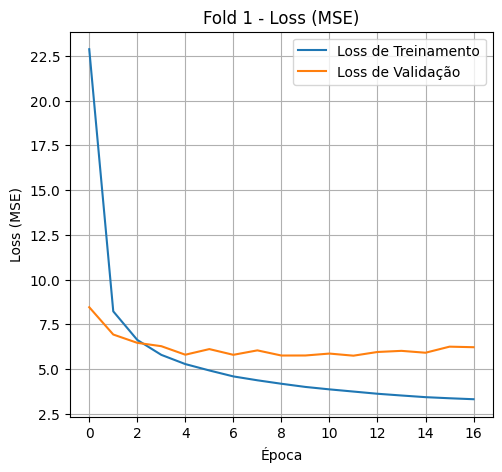


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 5.7461
Salvando modelo do fold 1 em: submodels/submodel_fold_1.keras

--- Iniciando Fold 2/10 ---
Epoch 1/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - loss: 53.8153 - val_loss: 5.9263 - learning_rate: 1.0000e-06
Epoch 2/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - loss: 9.4905 - val_loss: 4.2953 - learning_rate: 1.0000e-06
Epoch 3/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 7.3339 - val_loss: 3.7454 - learning_rate: 1.0000e-06
Epoch 4/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 6.3328 - val_loss: 3.5915 - learning_rate: 1.0000e-06
Epoch 5/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 5.7113 - val_loss: 3.4556 - learning_rate: 1.0000e-06
Epoch 6/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 5.2843 - val_loss: 3.3119 - learning_rate: 1.0000e-06
Epoch 7/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 4.9899 - val_loss: 3.2352 - learning_rate: 1.0000e-06
Epoch 8/50
2453/

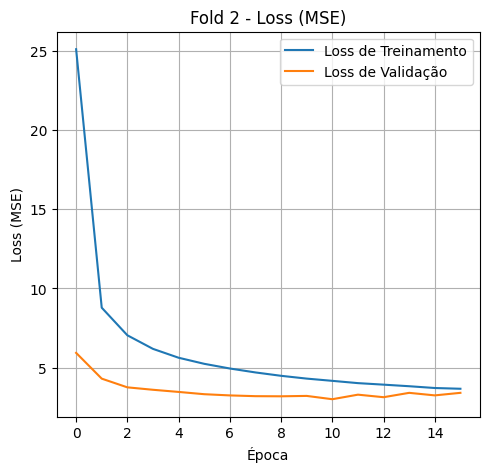


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 2.9944
Salvando modelo do fold 2 em: submodels/submodel_fold_2.keras

--- Iniciando Fold 3/10 ---
Epoch 1/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step - loss: 50.2790 - val_loss: 6.4566 - learning_rate: 1.0000e-06
Epoch 2/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 9.7583 - val_loss: 4.6209 - learning_rate: 1.0000e-06
Epoch 3/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 7.5270 - val_loss: 3.9385 - learning_rate: 1.0000e-06
Epoch 4/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 6.5361 - val_loss: 3.4263 - learning_rate: 1.0000e-06
Epoch 5/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.9255 - val_loss: 3.3354 - learning_rate: 1.0000e-06
Epoch 6/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.4458 - val_loss: 3.1649 - learning_rate: 1.0000e-06
Epoch 7/50
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 5.0944 - val_loss: 3.3133 - learning_rate: 1.0000e-06
Epoch 8/50
2444/

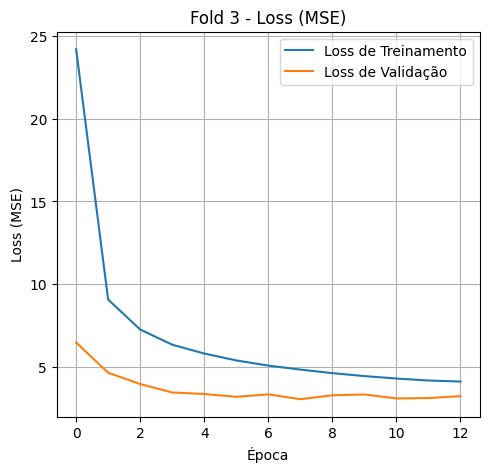


Avaliação do Fold 3 no conjunto de validação:
Loss (MSE): 3.0189
Salvando modelo do fold 3 em: submodels/submodel_fold_3.keras

--- Iniciando Fold 4/10 ---
Epoch 1/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - loss: 53.9978 - val_loss: 9.2134 - learning_rate: 1.0000e-06
Epoch 2/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 9.3790 - val_loss: 7.1338 - learning_rate: 1.0000e-06
Epoch 3/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 7.2098 - val_loss: 6.3488 - learning_rate: 1.0000e-06
Epoch 4/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 6.2264 - val_loss: 5.9508 - learning_rate: 1.0000e-06
Epoch 5/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 5.6099 - val_loss: 5.6989 - learning_rate: 1.0000e-06
Epoch 6/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 5.1485 - val_loss: 5.3923 - learning_rate: 1.0000e-06
Epoch 7/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 4.7979 - val_loss: 5.4114 - learning_rate: 1.0000e-06
Epoch 8/50
2460/

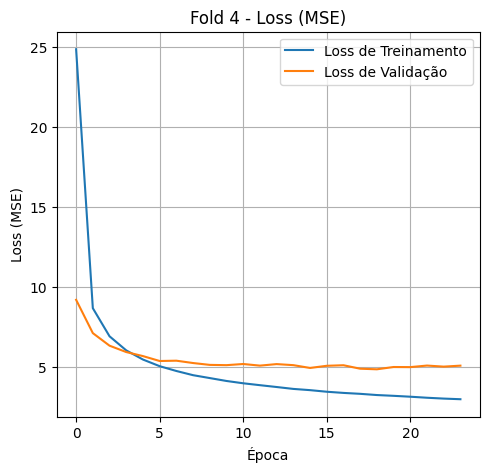


Avaliação do Fold 4 no conjunto de validação:
Loss (MSE): 4.8742
Salvando modelo do fold 4 em: submodels/submodel_fold_4.keras

--- Iniciando Fold 5/10 ---
Epoch 1/50
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - loss: 57.3617 - val_loss: 6.2641 - learning_rate: 1.0000e-06
Epoch 2/50
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 9.4130 - val_loss: 4.4445 - learning_rate: 1.0000e-06
Epoch 3/50
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 7.2156 - val_loss: 3.7810 - learning_rate: 1.0000e-06
Epoch 4/50
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 6.1980 - val_loss: 3.4534 - learning_rate: 1.0000e-06
Epoch 5/50
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.5313 - val_loss: 3.2815 - learning_rate: 1.0000e-06
Epoch 6/50
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 5.1848 - val_loss: 3.1672 - learning_rate: 1.0000e-06
Epoch 7/50
2452/2452 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 4.8411 - val_loss: 3.2023 - learning_rate: 1.0000e-06
Epoch 8/50
2452/

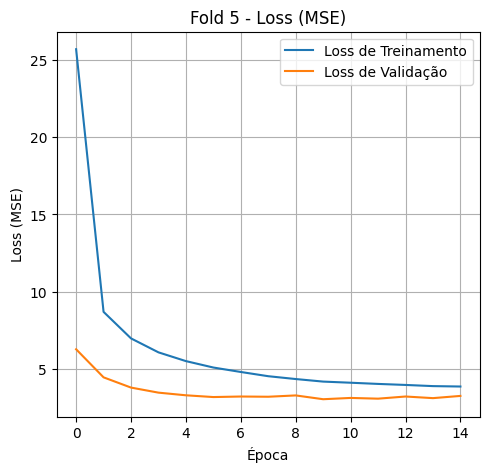


Avaliação do Fold 5 no conjunto de validação:
Loss (MSE): 3.0270
Salvando modelo do fold 5 em: submodels/submodel_fold_5.keras

--- Iniciando Fold 6/10 ---
Epoch 1/50
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 61s 22ms/step - loss: 61.1451 - val_loss: 7.2582 - learning_rate: 1.0000e-06
Epoch 2/50
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 9.7204 - val_loss: 5.2597 - learning_rate: 1.0000e-06
Epoch 3/50
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 7.6052 - val_loss: 4.3543 - learning_rate: 1.0000e-06
Epoch 4/50
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 6.4866 - val_loss: 3.8084 - learning_rate: 1.0000e-06
Epoch 5/50
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 5.8116 - val_loss: 3.5231 - learning_rate: 1.0000e-06
Epoch 6/50
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.3440 - val_loss: 3.2992 - learning_rate: 1.0000e-06
Epoch 7/50
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.0621 - val_loss: 3.2107 - learning_rate: 1.0000e-06
Epoch 8/50
2468/

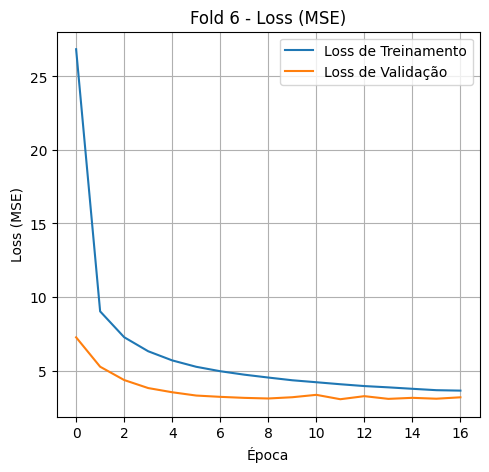


Avaliação do Fold 6 no conjunto de validação:
Loss (MSE): 3.0492
Salvando modelo do fold 6 em: submodels/submodel_fold_6.keras

--- Iniciando Fold 7/10 ---
Epoch 1/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - loss: 57.1258 - val_loss: 8.1107 - learning_rate: 1.0000e-06
Epoch 2/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 9.5720 - val_loss: 6.0375 - learning_rate: 1.0000e-06
Epoch 3/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 7.3234 - val_loss: 5.2107 - learning_rate: 1.0000e-06
Epoch 4/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 6.3598 - val_loss: 4.7795 - learning_rate: 1.0000e-06
Epoch 5/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.7211 - val_loss: 4.5688 - learning_rate: 1.0000e-06
Epoch 6/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.2033 - val_loss: 4.4977 - learning_rate: 1.0000e-06
Epoch 7/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 4.9304 - val_loss: 4.5393 - learning_rate: 1.0000e-06
Epoch 8/50
2458/

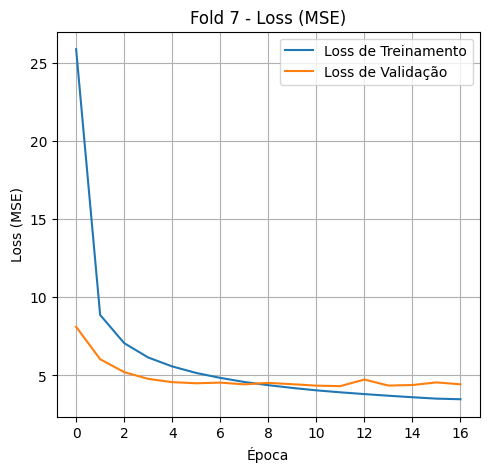


Avaliação do Fold 7 no conjunto de validação:
Loss (MSE): 4.3143
Salvando modelo do fold 7 em: submodels/submodel_fold_7.keras

--- Iniciando Fold 8/10 ---
Epoch 1/50
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - loss: 51.5411 - val_loss: 7.4711 - learning_rate: 1.0000e-06
Epoch 2/50
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 9.0827 - val_loss: 6.0396 - learning_rate: 1.0000e-06
Epoch 3/50
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 7.0126 - val_loss: 5.5085 - learning_rate: 1.0000e-06
Epoch 4/50
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 6.0415 - val_loss: 5.1203 - learning_rate: 1.0000e-06
Epoch 5/50
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - loss: 5.4400 - val_loss: 4.9396 - learning_rate: 1.0000e-06
Epoch 6/50
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 4.9751 - val_loss: 5.1211 - learning_rate: 1.0000e-06
Epoch 7/50
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 4.6585 - val_loss: 4.7429 - learning_rate: 1.0000e-06
Epoch 8/50
2456/

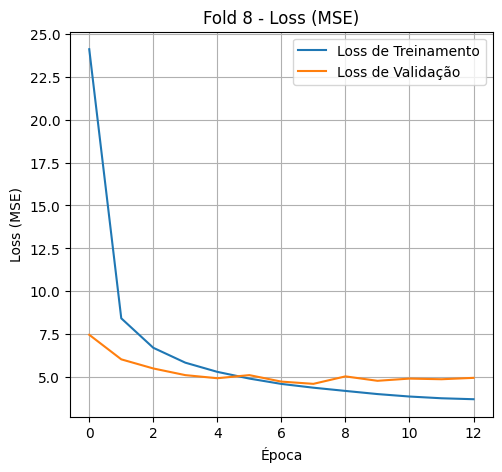


Avaliação do Fold 8 no conjunto de validação:
Loss (MSE): 4.6126
Salvando modelo do fold 8 em: submodels/submodel_fold_8.keras

--- Iniciando Fold 9/10 ---
Epoch 1/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 64s 24ms/step - loss: 55.9708 - val_loss: 7.9021 - learning_rate: 1.0000e-06
Epoch 2/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 9.6555 - val_loss: 5.5652 - learning_rate: 1.0000e-06
Epoch 3/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 7.3979 - val_loss: 4.7626 - learning_rate: 1.0000e-06
Epoch 4/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - loss: 6.3436 - val_loss: 4.4996 - learning_rate: 1.0000e-06
Epoch 5/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 5.7553 - val_loss: 4.4375 - learning_rate: 1.0000e-06
Epoch 6/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - loss: 5.3065 - val_loss: 4.4049 - learning_rate: 1.0000e-06
Epoch 7/50
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 5.0321 - val_loss: 4.3606 - learning_rate: 1.0000e-06
Epoch 8/50
2458/

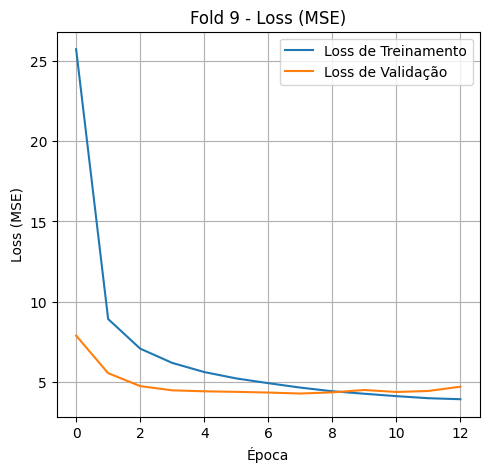


Avaliação do Fold 9 no conjunto de validação:
Loss (MSE): 4.3001
Salvando modelo do fold 9 em: submodels/submodel_fold_9.keras

--- Iniciando Fold 10/10 ---
Epoch 1/50
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 63s 23ms/step - loss: 45.0167 - val_loss: 4.8974 - learning_rate: 1.0000e-06
Epoch 2/50
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 9.4354 - val_loss: 3.8395 - learning_rate: 1.0000e-06
Epoch 3/50
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 7.2871 - val_loss: 3.3639 - learning_rate: 1.0000e-06
Epoch 4/50
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 6.3337 - val_loss: 3.2693 - learning_rate: 1.0000e-06
Epoch 5/50
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.6513 - val_loss: 3.1333 - learning_rate: 1.0000e-06
Epoch 6/50
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 5.2465 - val_loss: 3.0291 - learning_rate: 1.0000e-06
Epoch 7/50
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 4.8616 - val_loss: 3.1547 - learning_rate: 1.0000e-06
Epoch 8/50
2462

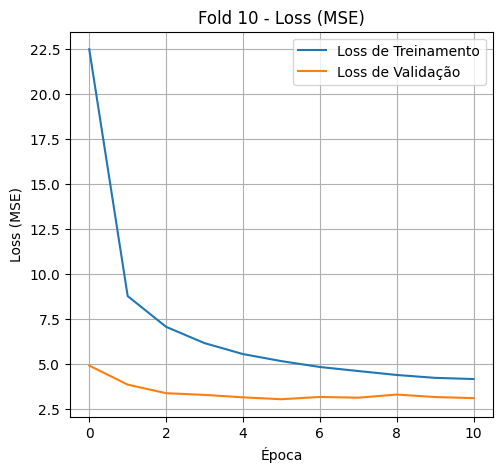


Avaliação do Fold 10 no conjunto de validação:
Loss (MSE): 3.0291
Salvando modelo do fold 10 em: submodels/submodel_fold_10.keras

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 5.7461
Fold 2: Loss (MSE) = 2.9944
Fold 3: Loss (MSE) = 3.0189
Fold 4: Loss (MSE) = 4.8742
Fold 5: Loss (MSE) = 3.0270
Fold 6: Loss (MSE) = 3.0492
Fold 7: Loss (MSE) = 4.3143
Fold 8: Loss (MSE) = 4.6126
Fold 9: Loss (MSE) = 4.3001
Fold 10: Loss (MSE) = 3.0291
Média da Loss (MSE) de Validação nos 10 Folds: 3.8966

Processo de validação cruzada concluído.
Gerando o gráfico da curva de validação média...


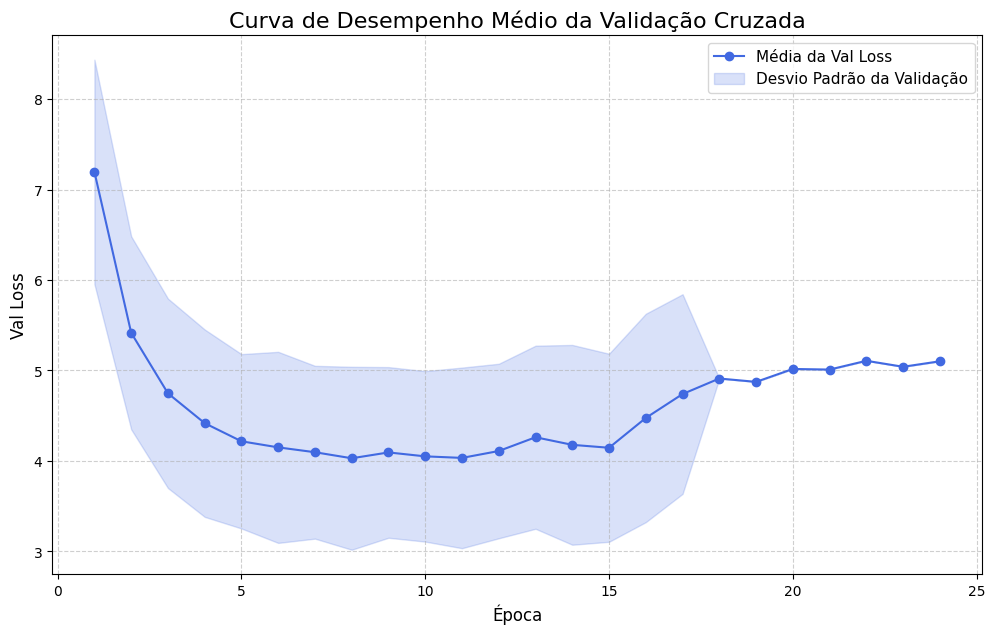

In [15]:
times_trainval = np.load(times_trainval_path, allow_pickle=True) 
dates_trainval = np.array([ts.date() for ts in times_trainval]) 
unique_dates_trainval = sorted(list(set(dates_trainval))) 
date_to_indices_trainval = {date: np.where(dates_trainval == date)[0] 
                   for date in unique_dates_trainval}

lr = 1e-6
bs = 128

avg_loss, fold_histories, submodel_paths = cross_val(
    unique_dates=unique_dates_trainval,
    date_to_indices=date_to_indices_trainval,
    learning_rate=lr,
    batch_size=bs,
    reduce_lr_patience=3,
    earlystop_patience=5,
    num_epochs=50,
    k_splits=10  
)


print("\nProcesso de validação cruzada concluído.")
print("Gerando o gráfico da curva de validação média...")

plot_average_validation_curve(fold_histories, metric='val_loss')

In [17]:
num_fold = len(fold_histories)

best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

print("--- Resumo do Desempenho por Fold (no melhor ponto de validação) ---")

for i in range(num_fold):
    min_val_loss = np.min(fold_histories[i]['val_loss'])
    best_val_loss_MSE[i] = min_val_loss
    best_epoch_idx = np.argmin(fold_histories[i]['val_loss'])
    corresponding_train_loss = fold_histories[i]['loss'][best_epoch_idx]
    best_train_loss_MSE[i] = corresponding_train_loss
    
    print('Modelo do Fold {0:2d} -- RMSE de Treino: {1:.4f}, RMSE de Validação: {2:.4f} (na época {3})'.format(
        i + 1, 
        np.sqrt(best_train_loss_MSE[i]), 
        np.sqrt(best_val_loss_MSE[i]),
        best_epoch_idx + 1
    ))

mean_train_rmse = np.mean(np.sqrt(best_train_loss_MSE))
mean_val_rmse = np.mean(np.sqrt(best_val_loss_MSE))

print("\n--- Média Final ---")
print('O RMSE médio de treino para todos os modelos é: {0:.4f}'.format(mean_train_rmse))
print('O RMSE médio de validação para todos os modelos é: {0:.4f}'.format(mean_val_rmse))

--- Resumo do Desempenho por Fold (no melhor ponto de validação) ---
Modelo do Fold  1 -- RMSE de Treino: 1.9345, RMSE de Validação: 2.3971 (na época 12)
Modelo do Fold  2 -- RMSE de Treino: 2.0387, RMSE de Validação: 1.7304 (na época 11)
Modelo do Fold  3 -- RMSE de Treino: 2.1941, RMSE de Validação: 1.7375 (na época 8)
Modelo do Fold  4 -- RMSE de Treino: 1.8073, RMSE de Validação: 2.2078 (na época 19)
Modelo do Fold  5 -- RMSE de Treino: 2.0419, RMSE de Validação: 1.7398 (na época 10)
Modelo do Fold  6 -- RMSE de Treino: 2.0169, RMSE de Validação: 1.7462 (na época 12)
Modelo do Fold  7 -- RMSE de Treino: 1.9797, RMSE de Validação: 2.0771 (na época 12)
Modelo do Fold  8 -- RMSE de Treino: 2.0948, RMSE de Validação: 2.1477 (na época 8)
Modelo do Fold  9 -- RMSE de Treino: 2.1608, RMSE de Validação: 2.0737 (na época 8)
Modelo do Fold 10 -- RMSE de Treino: 2.2682, RMSE de Validação: 1.7404 (na época 6)

--- Média Final ---
O RMSE médio de treino para todos os modelos é: 2.0537
O RMSE mé

### Salvando históricos de treinamento

In [25]:
output_dir = '/kaggle/working/'
file_name = 'training_histories.npy'
output_path = os.path.join(output_dir, file_name)

os.makedirs(output_dir, exist_ok=True)

print(f"\nSalvando os históricos de treinamento em: {output_path}")

# np.save irá serializar o objeto Python (lista de dicionários) e salvá-lo.
np.save(output_path, fold_histories)

print("Históricos salvos com sucesso!")


Salvando os históricos de treinamento em: /kaggle/working/training_histories.npy
Históricos salvos com sucesso!


## Resultados no Conjunto de Teste - SUNSET

In [4]:
def predict_with_ensemble(model_paths, test_images_np, batch_size=256):
    """
    Carrega vários submodelos, faz previsões a partir de arrays NumPy e retorna a média (ensemble).

    Args:
        model_paths (list[str]): Uma lista de caminhos para os arquivos .keras dos submodelos.
        test_images_np (np.ndarray): O array NumPy com as imagens de teste.
        batch_size (int): O tamanho do lote para a predição, para evitar problemas de memória.

    Returns:
        np.ndarray: Um array com as previsões finais do ensemble.
    """
    all_predictions = []

    print(f"\nIniciando predição com ensemble de {len(model_paths)} modelos...")

    for path in model_paths:
        print(f"Carregando e prevendo com o modelo: {path}")
        # Carrega o submodelo salvo
        model = keras.models.load_model(path, compile=False)
        
        # Faz a predição diretamente no array NumPy de imagens
        # Usar um batch_size na predição é uma boa prática para não sobrecarregar a memória
        predictions = model.predict(test_images_np, batch_size=batch_size)
        all_predictions.append(predictions)

    # Empilha as previsões para facilitar o cálculo da média
    stacked_predictions = np.stack(all_predictions)

    # Calcula a média ao longo do eixo dos modelos (axis=0)
    ensemble_prediction = np.mean(stacked_predictions, axis=0)

    print("Predição com ensemble concluída.")
    return ensemble_prediction

In [5]:
from sklearn.metrics import mean_squared_error


times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...] 

images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

submodel_paths = [os.path.join('/kaggle/input/submodelos-sunset/keras/default/1', f'submodel_fold_{i}.keras') for i in range(1, 11)]

final_predictions = predict_with_ensemble(
    model_paths=submodel_paths,
    test_images_np=images_log_test,
    batch_size=200 
)

test_rmse = np.sqrt(mean_squared_error(pv_log_test, final_predictions))

print('-'*51)
print(f"RMSE Final do Ensemble no Conjunto de Teste: {test_rmse:.4f}")

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)

Iniciando predição com ensemble de 10 modelos...
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/submodel_fold_1.keras


I0000 00:00:1751942505.009823      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1751942509.352533      96 service.cc:148] XLA service 0x7c45a40042d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751942509.353365      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751942509.458528      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


23/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

I0000 00:00:1751942510.749836      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/submodel_fold_2.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/submodel_fold_3.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/submodel_fold_4.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/submodel_fold_5.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/submodel_fold_6.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/submodel_fold_7.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Carregando e prevendo com o modelo: /kaggle/input/submodelos-sunset/keras/default/1/

Como podemos ver acima, o desempenho final do modelo aintigiu bons resultados, reproduzindo com fidelidade o RMSE do artigo.

### Comparação de desempenho para dias nublados e ensolarados.

In [6]:
# Definição dos dias ensolarados e nublados para análise
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

# Criação de máscaras para separar os dados de dias ensolarados e nublados
mask = np.zeros(len(pv_log_test), dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]] = 1

# Aplica a máscara para obter os subconjuntos de dados
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
predictions_ensemble_sunny = final_predictions[mask] 
print("times_test_sunny.shape:", times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
predictions_ensemble_cloudy = final_predictions[~mask]
print("times_test_cloudy.shape:", times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [8]:
from sklearn.metrics import mean_absolute_error

# Cálculo do RMSE e MAE para cada tipo de dia
rmse_sunny = np.sqrt(mean_squared_error(pv_log_test_sunny, predictions_ensemble_sunny))
rmse_cloudy = np.sqrt(mean_squared_error(pv_log_test_cloudy, predictions_ensemble_cloudy))
rmse_overall = np.sqrt(mean_squared_error(pv_log_test, final_predictions))

mae_sunny = mean_absolute_error(pv_log_test_sunny, predictions_ensemble_sunny)
mae_cloudy = mean_absolute_error(pv_log_test_cloudy, predictions_ensemble_cloudy)
mae_overall = mean_absolute_error(pv_log_test, final_predictions)

print(f"RMSE para dias ensolarados: {rmse_sunny:.3f}")
print(f"RMSE para dias nublados: {rmse_cloudy:.3f}")
print(f"RMSE geral no conjunto de teste: {rmse_overall:.3f}")

print(f"\nMAE para dias ensolarados: {mae_sunny:.3f}")
print(f"MAE para dias nublados: {mae_cloudy:.3f}")
print(f"MAE geral no conjunto de teste: {mae_overall:.3f}")

RMSE para dias ensolarados: 0.865
RMSE para dias nublados: 3.356
RMSE geral no conjunto de teste: 2.453

MAE para dias ensolarados: 0.718
MAE para dias nublados: 2.361
MAE geral no conjunto de teste: 1.541


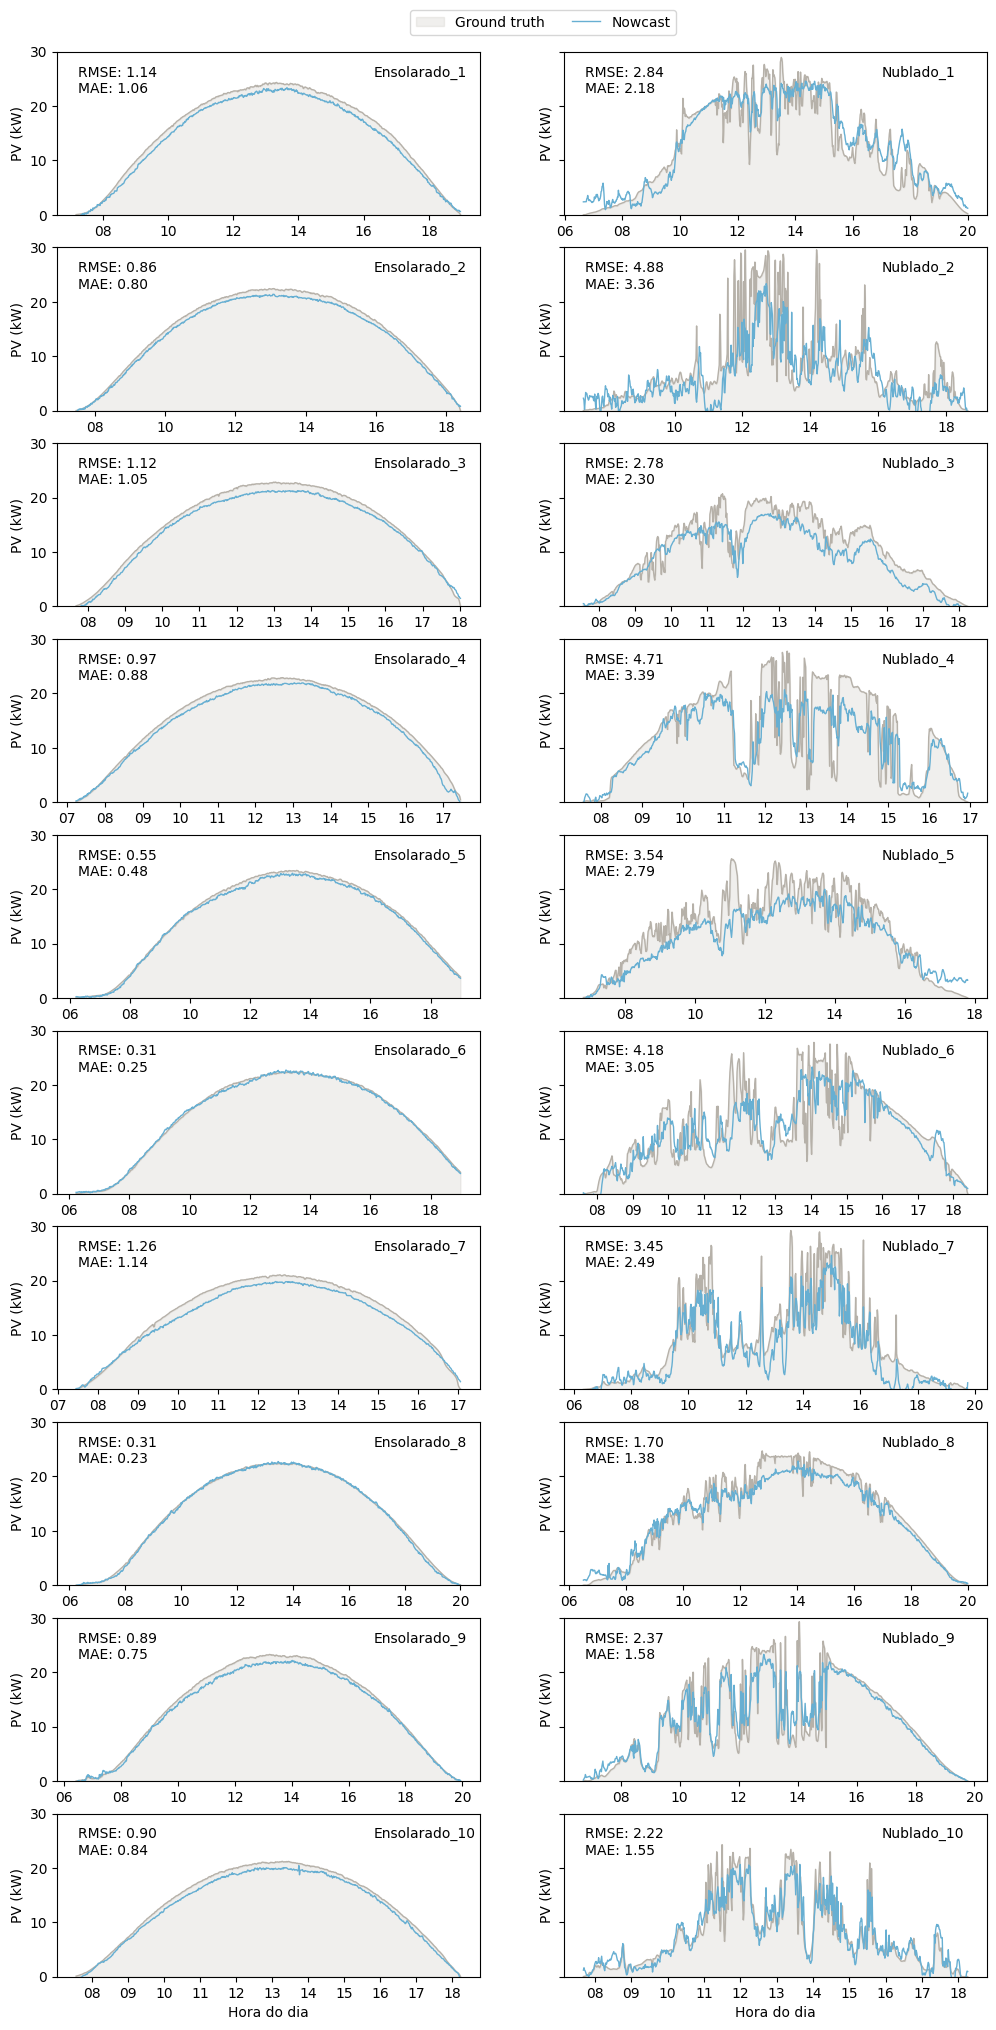

In [14]:
import matplotlib.dates as mdates

# Visualização das previsões dia a dia
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f, axarr = plt.subplots(10, 2, sharey=True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000, 1, 1)

blue = '#67AFD2'
grey = '#B6B1A9'

# Loop para dias ensolarados
for i, date in enumerate(sunny_dates_test):
    ax = axarr[i, 0]
    date_mask = (dates_test == date)
    hours_xaxis = [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]
    
    rmse = np.sqrt(mean_squared_error(pv_log_test[date_mask], final_predictions[date_mask]))
    mae = mean_absolute_error(pv_log_test[date_mask], final_predictions[date_mask])
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth=1, color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label='Ground truth')
    ax.plot(hours_xaxis, final_predictions[date_mask], linewidth=1, label='Nowcast', color=blue, markerfacecolor="None")
    ax.set_ylabel('PV (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75, 0.85, 'Ensolarado_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05, 0.75, f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}", transform=ax.transAxes)

# Loop para dias nublados
for i, date in enumerate(cloudy_dates_test):
    ax = axarr[i, 1]
    date_mask = (dates_test == date)
    hours_xaxis = [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]
    
    rmse = np.sqrt(mean_squared_error(pv_log_test[date_mask], final_predictions[date_mask]))
    mae = mean_absolute_error(pv_log_test[date_mask], final_predictions[date_mask])
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth=1, color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label='Ground truth')
    ax.plot(hours_xaxis, final_predictions[date_mask], linewidth=1, label='Nowcast', color=blue, markerfacecolor="None")
    ax.set_ylabel('PV (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75, 0.85, 'Nublado_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05, 0.75, f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}", transform=ax.transAxes)

# Configurações finais do plot
axarr[0, 0].set_ylim(0, 30)
axarr[0, 0].legend(bbox_to_anchor=[1.15, 1.3], loc='upper center', ncol=2)
axarr[-1, 0].set_xlabel('Hora do dia')
axarr[-1, 1].set_xlabel('Hora do dia')

f.set_size_inches(12, 25)
plt.show()

## Fine-Tunning - ResNet50V2

Nessa etapa será realizado um fine-tunnig de um modelo pré-treinado com os pesos da ImgeNet. A arquitetura do Keras Applications escolhida como backbone foi a ResNet50V2.

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import time
import random
import datetime
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras import layers
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input

2025-07-08 13:01:33.527518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751979693.706324      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751979693.759607      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_folder = "/kaggle/input/skippd"
data_path = os.path.join(data_folder, "2017_2019_images_pv_processed.hdf5")
times_trainval_path = os.path.join(data_folder, "times_trainval.npy")
times_test_path = os.path.join(data_folder, "times_test.npy")

print("data_folder:", data_folder)
print("data_path:", data_path)
print("times_trainval_path:", times_trainval_path)
print("times_test_path:", times_test_path)

skippd_dataset = h5py.File(data_path, 'r')

data_folder: /kaggle/input/skippd
data_path: /kaggle/input/skippd/2017_2019_images_pv_processed.hdf5
times_trainval_path: /kaggle/input/skippd/times_trainval.npy
times_test_path: /kaggle/input/skippd/times_test.npy


In [3]:
img_side_len = skippd_dataset['trainval']['images_log'].shape[1]
num_color_channel = skippd_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

In [4]:
def create_dataset(is_test, batch_size, sample_indices_np, hdf5_data_path_str):
    """
    Cria uma pipeline de dados tf.data com embaralhamento completo de índices e carregamento de imagens e valores PV do arquivo HDF5.

    Args:
    - is_test (bool): True se for um conjunto de teste/validação (sem shuffle), False para treino (com shuffle).
    - batch_size (int): O tamanho do lote de dados.
    - sample_indices_np (np.array): Array NumPy contendo os índices das amostras (ex: fold_train_sample_indices ou fold_val_sample_indices).
    - hdf5_data_path_str (str): O caminho para o arquivo .hdf5.
    """
    hdf5_data_path_tensor = tf.constant(hdf5_data_path_str, dtype=tf.string)
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_indices_np)
    
    if not is_test: # Para teste/validação não se faz shuffle 
        idx_ds = idx_ds.shuffle(buffer_size=len(sample_indices_np), reshuffle_each_iteration=True) # Shuffle ANTES do batch
    idx_ds = idx_ds.batch(batch_size) 

    def load_batch_data(sample_indices_batch_tf): # Função que será mapeada em cima de idx_ds    
        
        def _load_batch_data_np(indices_batch, data_path_decoded_tensor): # Função que interage diretamente com o arquivo HDF5
            indices_np = indices_batch.numpy() 
            data_path_decoded_str = data_path_decoded_tensor.numpy().decode('utf-8')
            sorted_indices_np = sorted(indices_np) # Ordenar índices do lote antes de ler o HDF5. Ler arquivos de forma ordenada é mais rápido que ler os índices do batch que estão aleatorizados. 

            with h5py.File(data_path_decoded_str, 'r') as f: 
                images = f['/trainval/images_log'][sorted_indices_np]
                pvs = f['/trainval/pv_log'][sorted_indices_np]

                images = tf.image.convert_image_dtype(images, tf.float32).numpy() # Converte para NumPy para retornar via py_function
                pvs = tf.cast(pvs, tf.float32).numpy()
            
            return images, pvs

        images_batch_tensor, pvs_batch_tensor = tf.py_function(func=_load_batch_data_np, inp=[sample_indices_batch_tf, hdf5_data_path_tensor],Tout=(tf.float32, tf.float32))
        images_batch_tensor.set_shape([None, img_side_len, img_side_len, num_color_channel]) # None na primeira dimensão indica um tamanho de lote flexível (o último lote de um dataset pode ser menor que batch_size).
        pvs_batch_tensor.set_shape([None])

        return images_batch_tensor, pvs_batch_tensor

    
    dataset = idx_ds.map(load_batch_data, num_parallel_calls=tf.data.AUTOTUNE) # Ao ser chamda com map, a função é aplicada a cada batch de índices de idx_ds.
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [5]:
def plot_training_history(history, fold_name="", lr=None, bs=None):
    """
    Plota histórico de treinamento.
    """
    plt.figure(figsize=(12, 5))

    title_suffix = ""
    if lr is not None: title_suffix += f" LR={lr}"
    if bs is not None: title_suffix += f" BS={bs}"

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Loss de Treinamento')
    if 'val_loss' in history: plt.plot(history['val_loss'], label='Loss de Validação')
    plt.title(f'{fold_name} - Loss (MSE){title_suffix}')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    plt.show()

In [6]:
def cv_split(unique_dates, date_to_indices, train_indices, val_indices):
    """
     Função que retorna os índices de treinamento e validação para cada fold.
     A função deve ser chamada a cada fold.
     
     - unique_dates: array contendo as datas únicas presentes no conjunto.
     - date_to_indices: dicionário contendo que agrupa os índices do conjunto por data.
     - train_indices e val_indices: índices de cada fold fornecidos pelo kf.split, onde o split é feito no array unique_dates.
     - pv_np e images_np: arrays np carregados do arquivo hdf5.
     """

    # Obter as datas reais para o fold
    train_dates = [unique_dates[i] for i in train_indices]
    val_dates = [unique_dates[i] for i in val_indices]
    
    # Obter os índices reais das amostras para o fold
    train_real_indices = np.concatenate([date_to_indices[d] for d in train_dates])
    val_real_indices = np.concatenate([date_to_indices[d] for d in val_dates])
    
    return train_real_indices, val_real_indices

In [7]:
def cross_val(model_builder, unique_dates, date_to_indices, learning_rate, batch_size,
              reduce_lr_patience, earlystop_patience, num_epochs, k_splits, models_dir='submodels'):
    """
    Função de validação cruzada adaptada para salvar cada submodelo treinado em um diretório.
    """
    # Cria um diretório para salvar os modelos, se não existir
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
    fold_histories = []
    fold_eval_results = []
    saved_model_paths = [] # Lista para guardar os caminhos dos modelos salvos

    print(f"\nIniciando treinamento com {k_splits}-Fold Cross-Validation...")

    for fold_idx, (train_date_indices, val_date_indices) in enumerate(kf.split(unique_dates)):
        print(f"\n--- Iniciando Fold {fold_idx + 1}/{k_splits} ---")
        keras.backend.clear_session()

        fold_train_indices, fold_val_indices = cv_split(unique_dates, date_to_indices, train_date_indices, val_date_indices)
        
        train_dataset_fold = create_dataset(is_test=False, batch_size=batch_size, sample_indices_np=fold_train_indices, hdf5_data_path_str=data_path)
        val_dataset_fold = create_dataset(is_test=True, batch_size=batch_size, sample_indices_np=fold_val_indices, hdf5_data_path_str=data_path)
    
        model = model_builder()
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
    
        earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_patience, min_lr=1e-8, verbose=1)
    
        history = model.fit(train_dataset_fold, epochs=num_epochs, validation_data=val_dataset_fold, callbacks=[earlystop, reduce_lr], verbose=1)
        fold_histories.append(history.history)
        
        plot_training_history(history.history, fold_name=f"Fold {fold_idx + 1}")
    
        print(f"\nAvaliação do Fold {fold_idx + 1} no conjunto de validação:")
        val_loss = model.evaluate(val_dataset_fold, verbose=0)
        print(f"Loss (MSE): {val_loss:.4f}")
        fold_eval_results.append({'loss': val_loss})

        # Salvando submodelo atual
        model_path = os.path.join(models_dir, f'submodel_fold_{fold_idx + 1}.keras')
        print(f"Salvando modelo do fold {fold_idx + 1} em: {model_path}")
        model.save(model_path)
        saved_model_paths.append(model_path)


    print("\n--- Resumo dos Resultados do K-Fold ---")
    for i, results in enumerate(fold_eval_results):
        print(f"Fold {i + 1}: Loss (MSE) = {results['loss']:.4f}")
    
    avg_loss = np.mean([r['loss'] for r in fold_eval_results])
    print(f"Média da Loss (MSE) de Validação nos {k_splits} Folds: {avg_loss:.4f}")
    
    return avg_loss, fold_histories, saved_model_paths

In [8]:
def plot_average_validation_curve(histories, metric='val_loss'):
    """
    Plota a curva de desempenho médio de validação entre todos os folds,
    com uma região sombreada representando o desvio padrão.

    Args:
        histories (list[dict]): Uma lista contendo os dicionários de histórico
            (history.history) de cada fold.
        metric (str): A métrica de validação a ser plotada (ex: 'val_loss',
            'val_root_mean_squared_error').
    """
    # Extrair a métrica de validação de cada histórico de fold
    val_curves = [h[metric] for h in histories if metric in h]
    if not val_curves:
        print(f"Métrica '{metric}' não encontrada nos históricos.")
        return

    # Lidar com comprimentos de épocas diferentes (devido ao EarlyStopping)
    max_epochs = max(len(curve) for curve in val_curves) # Encontra o número máximo de épocas em qualquer um dos folds

    # Cria um array 2D preenchido com NaN (Not a Number)
    # Dimensões: (número de folds) x (número máximo de épocas)
    padded_curves = np.full((len(val_curves), max_epochs), np.nan)

    # Preenche o array com os dados de cada curva
    for i, curve in enumerate(val_curves):
        padded_curves[i, :len(curve)] = curve

    # Calcular a média e o desvio padrão em cada época, ignorando os NaNs
    mean_curve = np.nanmean(padded_curves, axis=0)
    std_curve = np.nanstd(padded_curves, axis=0)

    # Limita o desvio padrão para que a curva inferior não seja menor que zero
    std_curve = np.minimum(std_curve, mean_curve)

    # Calcular os limites superior e inferior da região sombreada
    upper_bound = mean_curve + std_curve
    lower_bound = mean_curve - std_curve

    # Plotar o gráfico
    epochs = np.arange(max_epochs) + 1
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, mean_curve, 'o-', color='royalblue', label=f'Média da {metric.replace("_", " ").title()}') # Plota a curva da média

    
    plt.fill_between(epochs, lower_bound, upper_bound, color='royalblue', alpha=0.2, label=f'Desvio Padrão da Validação') # Plota a região sombreada (hachurada)

    plt.title('Curva de Desempenho Médio da Validação Cruzada', fontsize=16)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [9]:
def predict_with_ensemble(model_paths, test_images_np, batch_size=256):
    """
    Carrega vários submodelos, faz previsões a partir de arrays NumPy e retorna a média (ensemble).

    Args:
        model_paths (list[str]): Uma lista de caminhos para os arquivos .keras dos submodelos.
        test_images_np (np.ndarray): O array NumPy com as imagens de teste.
        batch_size (int): O tamanho do lote para a predição, para evitar problemas de memória.

    Returns:
        np.ndarray: Um array com as previsões finais do ensemble.
    """
    all_predictions = []

    print(f"\nIniciando predição com ensemble de {len(model_paths)} modelos...")

    for path in model_paths:
        print(f"Carregando e prevendo com o modelo: {path}")
        # Carrega o submodelo salvo
        model = keras.models.load_model(path, compile=False)
        
        # Faz a predição diretamente no array NumPy de imagens
        # Usar um batch_size na predição é uma boa prática para não sobrecarregar a memória
        predictions = model.predict(test_images_np, batch_size=batch_size)
        all_predictions.append(predictions)
        
    # Empilha as previsões para facilitar o cálculo da média
    stacked_predictions = np.stack(all_predictions)

    # Calcula a média ao longo do eixo dos modelos (axis=0)
    ensemble_prediction = np.mean(stacked_predictions, axis=0)

    print("Predição com ensemble concluída.")
    return ensemble_prediction

In [11]:
ResNet50V2().summary()

I0000 00:00:1751924780.041351      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [10]:
def build_resnet():
    base_model = ResNet50V2(include_top=False, input_shape=(64,64,3), pooling='avg', weights='imagenet')
    base_model.trainable = False
    
    for layer in base_model.layers:
        if not isinstance(layer, layers.BatchNormalization): # <-- BN layers should remain frozen
            layer.trainable = True
        
    keras.utils.set_random_seed(0) 
    inputs = layers.Input(shape=(64,64,3))
    
    x = inputs
    x = preprocess_input(x)
    x = base_model(x, training=False) # `training=False` é importante para camadas como BatchNormalization
    x = layers.Dropout(0.2)(x) # Adicionar uma camada de Dropout para regularização antes da saída final.
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    
    return model

In [13]:
model = build_resnet()
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 23,475,969 (89.55 MB)

 Non-trainable params: 90,880 (355.00 KB)

Teste com batch size e learning rate anteriores. Para acelerar os resultados sem comprometer tanto a robustez dos resultados, nessa etapa sera usado 5 folds ao invés de 10.

In [12]:
# Código para limpar os submodelos do útltimo treinamento

models_dir_to_clean = 'submodels'

if os.path.exists(models_dir_to_clean):
    shutil.rmtree(models_dir_to_clean)
    print(f"Pasta {models_dir_to_clean} apagada com sucesso.")

Pasta submodels apagada com sucesso.



Iniciando treinamento com 5-Fold Cross-Validation...

--- Iniciando Fold 1/5 ---
Epoch 1/15


I0000 00:00:1751728103.716362      95 service.cc:148] XLA service 0x7930e4004d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751728103.717013      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751728105.816205      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/2181 ━━━━━━━━━━━━━━━━━━━━ 2:16 63ms/step - loss: 210.0061 

I0000 00:00:1751728117.074107      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2181/2181 ━━━━━━━━━━━━━━━━━━━━ 316s 129ms/step - loss: 28.4529 - val_loss: 5.5369 - learning_rate: 1.0000e-06
Epoch 2/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 5.2688 - val_loss: 5.4764 - learning_rate: 1.0000e-06
Epoch 3/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.7327 - val_loss: 4.8242 - learning_rate: 1.0000e-06
Epoch 4/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 4.4746 - val_loss: 5.0145 - learning_rate: 1.0000e-06
Epoch 5/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.1878 - val_loss: 4.5389 - learning_rate: 1.0000e-06
Epoch 6/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.0120 - val_loss: 5.2107 - learning_rate: 1.0000e-06
Epoch 7/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 3.9098 - val_loss: 4.4814 - learning_rate: 1.0000e-06
Epoch 8/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - loss: 3.8206 - val_loss: 7.5754 - learning_rate: 1.0000e-06
Epoch 9/15
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step 

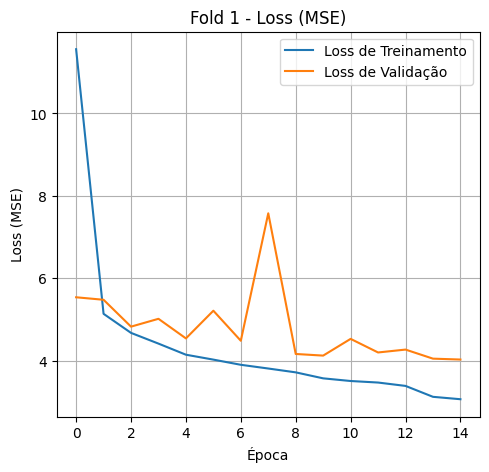


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 4.0258
Salvando modelo do fold 1 em: submodels/submodel_fold_1.keras

--- Iniciando Fold 2/5 ---
Epoch 1/15
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 201s 79ms/step - loss: 28.6366 - val_loss: 5.3729 - learning_rate: 1.0000e-06
Epoch 2/15
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 5.2721 - val_loss: 5.2475 - learning_rate: 1.0000e-06
Epoch 3/15
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 4.7152 - val_loss: 5.0815 - learning_rate: 1.0000e-06
Epoch 4/15
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.3800 - val_loss: 5.0160 - learning_rate: 1.0000e-06
Epoch 5/15
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.1460 - val_loss: 5.5581 - learning_rate: 1.0000e-06
Epoch 6/15
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 3.9439 - val_loss: 4.8903 - learning_rate: 1.0000e-06
Epoch 7/15
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 3.8390 - val_loss: 4.8094 - learning_rate: 1.0000e-06
Epoch 8/15

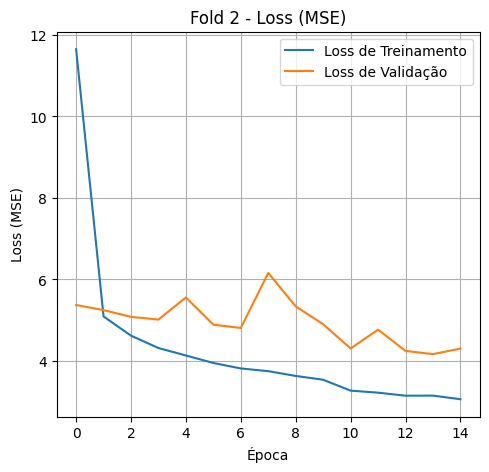


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 4.1674
Salvando modelo do fold 2 em: submodels/submodel_fold_2.keras

--- Iniciando Fold 3/5 ---
Epoch 1/15
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 198s 78ms/step - loss: 28.6422 - val_loss: 5.0388 - learning_rate: 1.0000e-06
Epoch 2/15
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 155s 70ms/step - loss: 5.4547 - val_loss: 4.2577 - learning_rate: 1.0000e-06
Epoch 3/15
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 155s 70ms/step - loss: 4.9152 - val_loss: 4.2242 - learning_rate: 1.0000e-06
Epoch 4/15
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 155s 70ms/step - loss: 4.5594 - val_loss: 4.1651 - learning_rate: 1.0000e-06
Epoch 5/15
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 155s 70ms/step - loss: 4.3823 - val_loss: 3.8150 - learning_rate: 1.0000e-06
Epoch 6/15
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 4.1203 - val_loss: 4.0848 - learning_rate: 1.0000e-06
Epoch 7/15
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.0186 - val_loss: 3.8448 - learning_rate: 1.0000e-06
Epoch 8/15

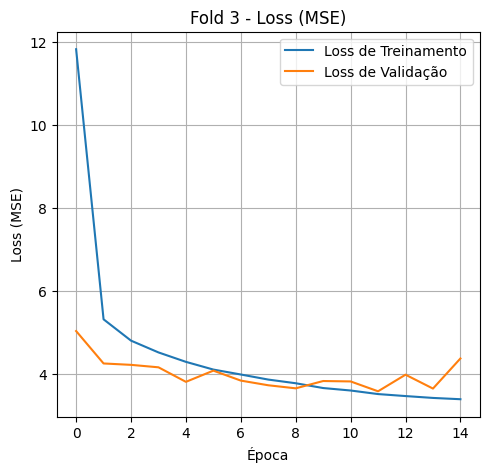


Avaliação do Fold 3 no conjunto de validação:
Loss (MSE): 3.5872
Salvando modelo do fold 3 em: submodels/submodel_fold_3.keras

--- Iniciando Fold 4/5 ---
Epoch 1/15
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 198s 78ms/step - loss: 28.5783 - val_loss: 7.2463 - learning_rate: 1.0000e-06
Epoch 2/15
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 5.1211 - val_loss: 5.7835 - learning_rate: 1.0000e-06
Epoch 3/15
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.6173 - val_loss: 5.6084 - learning_rate: 1.0000e-06
Epoch 4/15
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 157s 72ms/step - loss: 4.3152 - val_loss: 5.2689 - learning_rate: 1.0000e-06
Epoch 5/15
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 4.1281 - val_loss: 5.3906 - learning_rate: 1.0000e-06
Epoch 6/15
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 3.9038 - val_loss: 4.9531 - learning_rate: 1.0000e-06
Epoch 7/15
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 3.7308 - val_loss: 5.1416 - learning_rate: 1.0000e-06
Epoch 8/15

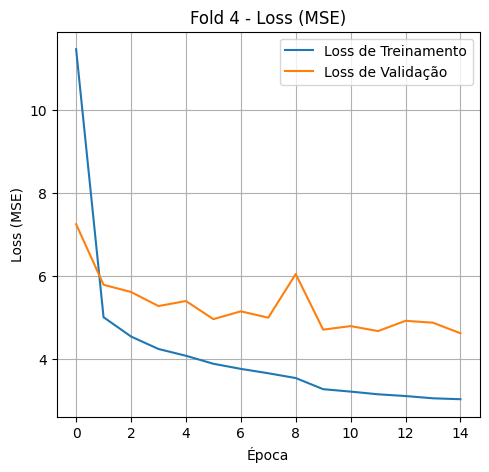


Avaliação do Fold 4 no conjunto de validação:
Loss (MSE): 4.6125
Salvando modelo do fold 4 em: submodels/submodel_fold_4.keras

--- Iniciando Fold 5/5 ---
Epoch 1/15
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 197s 78ms/step - loss: 28.6231 - val_loss: 4.1101 - learning_rate: 1.0000e-06
Epoch 2/15
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 5.5413 - val_loss: 3.8090 - learning_rate: 1.0000e-06
Epoch 3/15
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.9949 - val_loss: 4.2572 - learning_rate: 1.0000e-06
Epoch 4/15
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.6668 - val_loss: 3.8862 - learning_rate: 1.0000e-06
Epoch 5/15
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.4246 - val_loss: 3.4757 - learning_rate: 1.0000e-06
Epoch 6/15
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.2661 - val_loss: 3.3468 - learning_rate: 1.0000e-06
Epoch 7/15
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.0613 - val_loss: 3.5027 - learning_rate: 1.0000e-06
Epoch 8/15

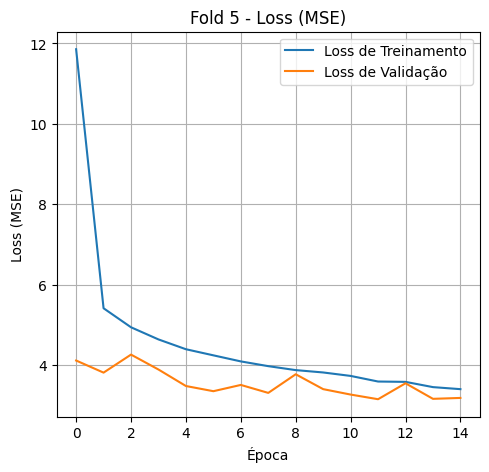


Avaliação do Fold 5 no conjunto de validação:
Loss (MSE): 3.1471
Salvando modelo do fold 5 em: submodels/submodel_fold_5.keras

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 4.0258
Fold 2: Loss (MSE) = 4.1674
Fold 3: Loss (MSE) = 3.5872
Fold 4: Loss (MSE) = 4.6125
Fold 5: Loss (MSE) = 3.1471
Média da Loss (MSE) de Validação nos 5 Folds: 3.9080


In [13]:
times_trainval = np.load(times_trainval_path, allow_pickle=True) 
dates_trainval = np.array([ts.date() for ts in times_trainval]) 
unique_dates_trainval = sorted(list(set(dates_trainval))) 
date_to_indices_trainval = {date: np.where(dates_trainval == date)[0] 
                   for date in unique_dates_trainval}

lr = 1e-6
bs = 128

avg_loss, fold_histories, submodel_paths = cross_val(
    model_builder=build_resnet,
    unique_dates=unique_dates_trainval,
    date_to_indices=date_to_indices_trainval,
    learning_rate=lr,
    batch_size=bs,
    reduce_lr_patience=3,
    earlystop_patience=5,
    num_epochs=15,
    k_splits=5  
)


Processo de validação cruzada concluído.
Gerando o gráfico da curva de validação média...


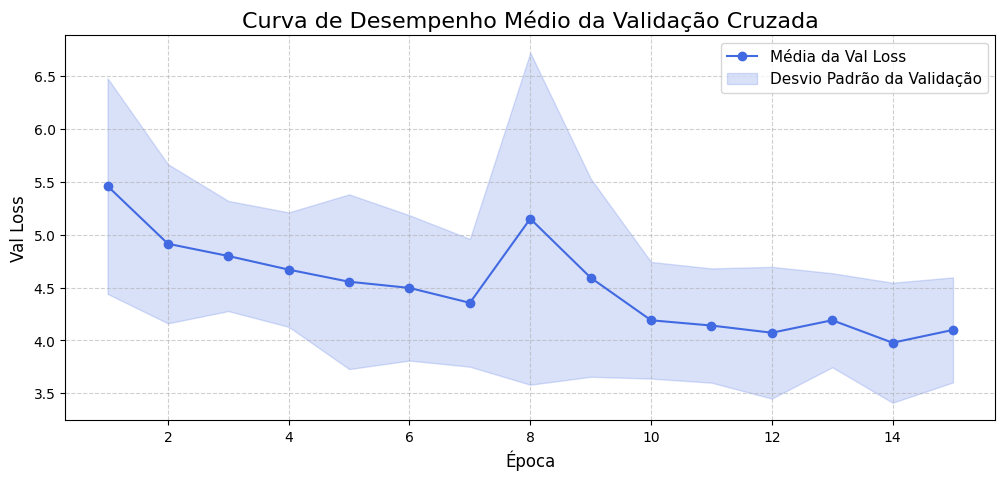

In [15]:
print("\nProcesso de validação cruzada concluído.")
print("Gerando o gráfico da curva de validação média...")

plot_average_validation_curve(fold_histories, metric='val_loss')

In [16]:
num_fold = len(fold_histories)

best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

print("--- Resumo do Desempenho por Fold (no melhor ponto de validação) ---")

for i in range(num_fold):
    min_val_loss = np.min(fold_histories[i]['val_loss'])
    best_val_loss_MSE[i] = min_val_loss
    best_epoch_idx = np.argmin(fold_histories[i]['val_loss'])
    corresponding_train_loss = fold_histories[i]['loss'][best_epoch_idx]
    best_train_loss_MSE[i] = corresponding_train_loss
    
    print('Modelo do Fold {0:2d} -- RMSE de Treino: {1:.4f}, RMSE de Validação: {2:.4f} (na época {3})'.format(
        i + 1, 
        np.sqrt(best_train_loss_MSE[i]), 
        np.sqrt(best_val_loss_MSE[i]),
        best_epoch_idx + 1
    ))

mean_train_rmse = np.mean(np.sqrt(best_train_loss_MSE))
mean_val_rmse = np.mean(np.sqrt(best_val_loss_MSE))

print("\n--- Média Final ---")
print('O RMSE médio de treino para todos os modelos é: {0:.4f}'.format(mean_train_rmse))
print('O RMSE médio de validação para todos os modelos é: {0:.4f}'.format(mean_val_rmse))

--- Resumo do Desempenho por Fold (no melhor ponto de validação) ---
Modelo do Fold  1 -- RMSE de Treino: 1.7500, RMSE de Validação: 2.0064 (na época 15)
Modelo do Fold  2 -- RMSE de Treino: 1.7745, RMSE de Validação: 2.0414 (na época 14)
Modelo do Fold  3 -- RMSE de Treino: 1.8762, RMSE de Validação: 1.8940 (na época 12)
Modelo do Fold  4 -- RMSE de Treino: 1.7377, RMSE de Validação: 2.1477 (na época 15)
Modelo do Fold  5 -- RMSE de Treino: 1.8940, RMSE de Validação: 1.7740 (na época 12)

--- Média Final ---
O RMSE médio de treino para todos os modelos é: 1.8065
O RMSE médio de validação para todos os modelos é: 1.9727


#### Salvando histórico de treinamento

In [17]:
output_dir = '/kaggle/working/'
file_name = 'training_histories_resnet.npy'
output_path = os.path.join(output_dir, file_name)

os.makedirs(output_dir, exist_ok=True)

print(f"\nSalvando os históricos de treinamento em: {output_path}")

# np.save irá serializar o objeto Python (lista de dicionários) e salvá-lo.
np.save(output_path, fold_histories)

print("Históricos salvos com sucesso!")


Salvando os históricos de treinamento em: /kaggle/working/training_histories_resnet.npy
Históricos salvos com sucesso!


In [23]:
from sklearn.metrics import mean_squared_error


times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...] 

images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

submodel_paths = [os.path.join('submodels', f'submodel_fold_{i}.keras') for i in range(1, 6)]

final_predictions = predict_with_ensemble(
    model_paths=submodel_paths,
    test_images_np=images_log_test,
    batch_size=200 
)

test_rmse = np.sqrt(mean_squared_error(pv_log_test, final_predictions))

print('-'*51)
print(f"RMSE Final do Ensemble no Conjunto de Teste: {test_rmse:.4f}")

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)

Iniciando predição com ensemble de 5 modelos...
Carregando e prevendo com o modelo: submodels/submodel_fold_1.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_2.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_3.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_4.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_5.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step
Predição com ensemble concluída.
---------------------------------------------------
RMSE Final do Ensemble no Conjunto de Teste: 2.7182


Como o histórico dos folds mostra a loss de validação atinge bons valores porém ainda é um pouco instável. Dessa forma, de forma a diminuir essa oscilação e também obter um melhor desempenho, a taxa de aprendizado será reduzida para 3e-7. Também, para dar mais tempo para o modelo convergir para um ponto ótimo, o númeor limite de épocas sera aumentado para 20.  


Iniciando treinamento com 5-Fold Cross-Validation...

--- Iniciando Fold 1/5 ---


I0000 00:00:1751811503.442469      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20


I0000 00:00:1751811532.030143      94 service.cc:148] XLA service 0x7d843c0023f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751811532.030827      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751811534.214020      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2181 ━━━━━━━━━━━━━━━━━━━━ 2:27 68ms/step - loss: 234.8858   

I0000 00:00:1751811545.590667      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2181/2181 ━━━━━━━━━━━━━━━━━━━━ 316s 129ms/step - loss: 51.4073 - val_loss: 6.1745 - learning_rate: 3.0000e-07
Epoch 2/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 6.0595 - val_loss: 5.9927 - learning_rate: 3.0000e-07
Epoch 3/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 5.3276 - val_loss: 5.2018 - learning_rate: 3.0000e-07
Epoch 4/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.9336 - val_loss: 5.1794 - learning_rate: 3.0000e-07
Epoch 5/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.6675 - val_loss: 5.1261 - learning_rate: 3.0000e-07
Epoch 6/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.4920 - val_loss: 4.9682 - learning_rate: 3.0000e-07
Epoch 7/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.4051 - val_loss: 4.7184 - learning_rate: 3.0000e-07
Epoch 8/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - loss: 4.2146 - val_loss: 4.8268 - learning_rate: 3.0000e-07
Epoch 9/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step 

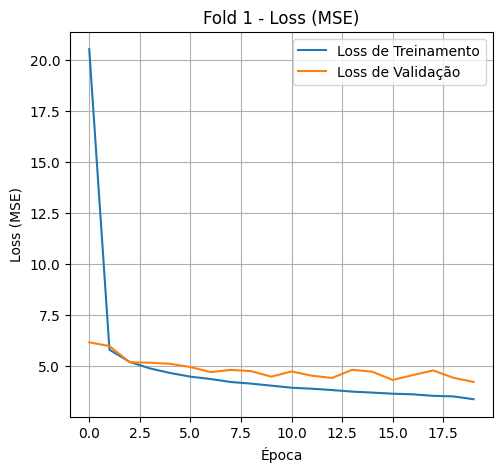


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 4.2384
Salvando modelo do fold 1 em: submodels/submodel_fold_1.keras

--- Iniciando Fold 2/5 ---
Epoch 1/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 199s 79ms/step - loss: 51.4189 - val_loss: 6.1420 - learning_rate: 3.0000e-07
Epoch 2/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 6.0817 - val_loss: 5.5183 - learning_rate: 3.0000e-07
Epoch 3/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 5.3573 - val_loss: 5.4218 - learning_rate: 3.0000e-07
Epoch 4/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.9485 - val_loss: 5.1271 - learning_rate: 3.0000e-07
Epoch 5/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 4.7140 - val_loss: 5.5337 - learning_rate: 3.0000e-07
Epoch 6/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 4.5063 - val_loss: 4.8294 - learning_rate: 3.0000e-07
Epoch 7/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - loss: 4.4011 - val_loss: 5.0668 - learning_rate: 3.0000e-07
Epoch 8/20

In [ ]:
times_trainval = np.load(times_trainval_path, allow_pickle=True) 
dates_trainval = np.array([ts.date() for ts in times_trainval]) 
unique_dates_trainval = sorted(list(set(dates_trainval))) 
date_to_indices_trainval = {date: np.where(dates_trainval == date)[0] 
                   for date in unique_dates_trainval}

lr = 3e-7
bs = 128

avg_loss, fold_histories, submodel_paths = cross_val(
    model_builder=build_resnet,
    unique_dates=unique_dates_trainval,
    date_to_indices=date_to_indices_trainval,
    learning_rate=lr,
    batch_size=bs,
    reduce_lr_patience=3,
    earlystop_patience=5,
    num_epochs=20,
    k_splits=5  
)

Infelizmente devido à um erro do Kaggle o treinamento travou, como é possível observar na saída da célula acima. Contudo, é possível perceber uma melhora na questão da oscilação.


Iniciando treinamento com 5-Fold Cross-Validation...

--- Iniciando Fold 1/5 ---
Epoch 1/20


I0000 00:00:1751828753.962585      96 service.cc:148] XLA service 0x7bbab4005590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751828753.963224      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751828756.120495      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2181 ━━━━━━━━━━━━━━━━━━━━ 2:26 67ms/step - loss: 212.2769   

I0000 00:00:1751828767.365491      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2181/2181 ━━━━━━━━━━━━━━━━━━━━ 311s 126ms/step - loss: 51.1640 - val_loss: 6.5435 - learning_rate: 3.0000e-07
Epoch 2/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 157s 72ms/step - loss: 6.0954 - val_loss: 5.5161 - learning_rate: 3.0000e-07
Epoch 3/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 5.3528 - val_loss: 5.3094 - learning_rate: 3.0000e-07
Epoch 4/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - loss: 5.0023 - val_loss: 5.1120 - learning_rate: 3.0000e-07
Epoch 5/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.7405 - val_loss: 4.9418 - learning_rate: 3.0000e-07
Epoch 6/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - loss: 4.5269 - val_loss: 5.0556 - learning_rate: 3.0000e-07
Epoch 7/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.4172 - val_loss: 4.7426 - learning_rate: 3.0000e-07
Epoch 8/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.2664 - val_loss: 6.0980 - learning_rate: 3.0000e-07
Epoch 9/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step 

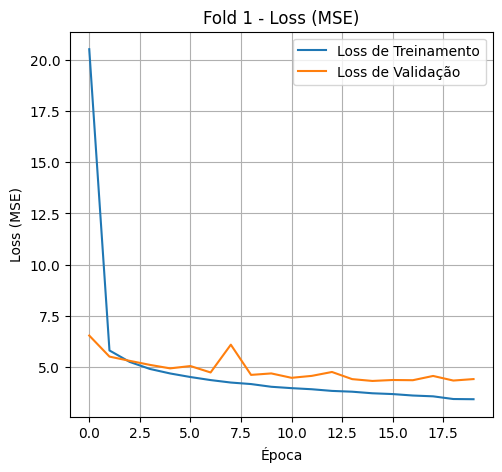


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 4.3281
Salvando modelo do fold 1 em: submodels/submodel_fold_1.keras

--- Iniciando Fold 2/5 ---
Epoch 1/20
2045/2174 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 53.3543

In [ ]:
times_trainval = np.load(times_trainval_path, allow_pickle=True) 
dates_trainval = np.array([ts.date() for ts in times_trainval]) 
unique_dates_trainval = sorted(list(set(dates_trainval))) 
date_to_indices_trainval = {date: np.where(dates_trainval == date)[0] 
                   for date in unique_dates_trainval}

lr = 3e-7
bs = 128

avg_loss, fold_histories, submodel_paths = cross_val(
    model_builder=build_resnet,
    unique_dates=unique_dates_trainval,
    date_to_indices=date_to_indices_trainval,
    learning_rate=lr,
    batch_size=bs,
    reduce_lr_patience=3,
    earlystop_patience=5,
    num_epochs=20,
    k_splits=5  
)

Infelizmente o treinamento travou novamente.


Iniciando treinamento com 5-Fold Cross-Validation...

--- Iniciando Fold 1/5 ---


I0000 00:00:1751953594.875571      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20


I0000 00:00:1751953622.924781      92 service.cc:148] XLA service 0x7e0bfc0025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751953622.925656      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751953625.053164      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2181 ━━━━━━━━━━━━━━━━━━━━ 2:24 66ms/step - loss: 228.0485   

I0000 00:00:1751953636.332494      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2181/2181 ━━━━━━━━━━━━━━━━━━━━ 293s 119ms/step - loss: 51.6695 - val_loss: 6.3076 - learning_rate: 3.0000e-07
Epoch 2/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 6.0595 - val_loss: 5.6327 - learning_rate: 3.0000e-07
Epoch 3/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 5.2974 - val_loss: 5.2515 - learning_rate: 3.0000e-07
Epoch 4/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.9617 - val_loss: 5.6898 - learning_rate: 3.0000e-07
Epoch 5/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.6482 - val_loss: 4.9821 - learning_rate: 3.0000e-07
Epoch 6/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.5048 - val_loss: 4.8868 - learning_rate: 3.0000e-07
Epoch 7/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.3560 - val_loss: 4.7778 - learning_rate: 3.0000e-07
Epoch 8/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 4.2697 - val_loss: 4.8095 - learning_rate: 3.0000e-07
Epoch 9/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step 

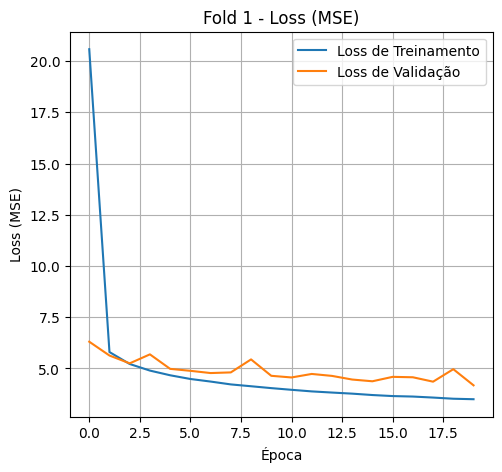


Avaliação do Fold 1 no conjunto de validação:
Loss (MSE): 4.1787
Salvando modelo do fold 1 em: submodels/submodel_fold_1.keras

--- Iniciando Fold 2/5 ---
Epoch 1/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 199s 79ms/step - loss: 51.4187 - val_loss: 6.1462 - learning_rate: 3.0000e-07
Epoch 2/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 6.0818 - val_loss: 5.5211 - learning_rate: 3.0000e-07
Epoch 3/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 5.3581 - val_loss: 5.4258 - learning_rate: 3.0000e-07
Epoch 4/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.9516 - val_loss: 5.1203 - learning_rate: 3.0000e-07
Epoch 5/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 4.7131 - val_loss: 5.5489 - learning_rate: 3.0000e-07
Epoch 6/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 4.5085 - val_loss: 4.8303 - learning_rate: 3.0000e-07
Epoch 7/20
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.3987 - val_loss: 5.0620 - learning_rate: 3.0000e-07
Epoch 8/20

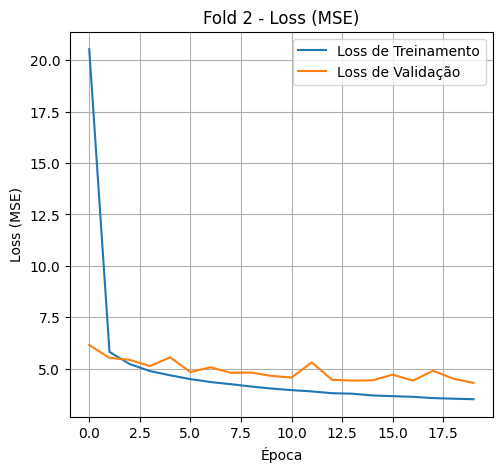


Avaliação do Fold 2 no conjunto de validação:
Loss (MSE): 4.3004
Salvando modelo do fold 2 em: submodels/submodel_fold_2.keras

--- Iniciando Fold 3/5 ---
Epoch 1/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 203s 80ms/step - loss: 51.8326 - val_loss: 5.0167 - learning_rate: 3.0000e-07
Epoch 2/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 157s 71ms/step - loss: 6.2591 - val_loss: 4.9104 - learning_rate: 3.0000e-07
Epoch 3/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 5.5547 - val_loss: 4.4085 - learning_rate: 3.0000e-07
Epoch 4/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 5.1602 - val_loss: 4.2753 - learning_rate: 3.0000e-07
Epoch 5/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.9613 - val_loss: 4.1192 - learning_rate: 3.0000e-07
Epoch 6/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.7049 - val_loss: 4.0604 - learning_rate: 3.0000e-07
Epoch 7/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - loss: 4.5284 - val_loss: 3.9891 - learning_rate: 3.0000e-07
Epoch 8/20

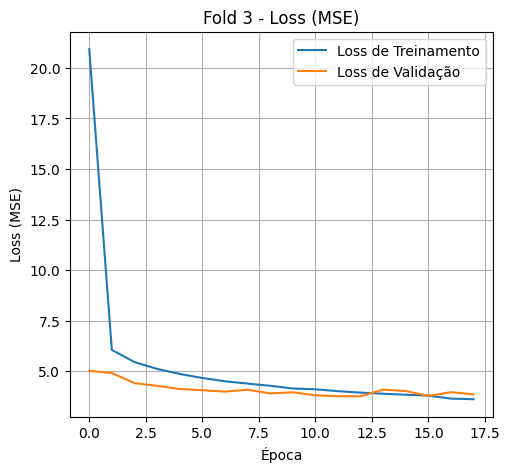


Avaliação do Fold 3 no conjunto de validação:
Loss (MSE): 3.7571
Salvando modelo do fold 3 em: submodels/submodel_fold_3.keras

--- Iniciando Fold 4/5 ---
Epoch 1/20
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 198s 79ms/step - loss: 51.1833 - val_loss: 6.9910 - learning_rate: 3.0000e-07
Epoch 2/20
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 5.8723 - val_loss: 6.3496 - learning_rate: 3.0000e-07
Epoch 3/20
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - loss: 5.1765 - val_loss: 6.0561 - learning_rate: 3.0000e-07
Epoch 4/20
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - loss: 4.8548 - val_loss: 5.8957 - learning_rate: 3.0000e-07
Epoch 5/20
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 4.6221 - val_loss: 5.7533 - learning_rate: 3.0000e-07
Epoch 6/20
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 4.3798 - val_loss: 5.7652 - learning_rate: 3.0000e-07
Epoch 7/20
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.2099 - val_loss: 5.6678 - learning_rate: 3.0000e-07
Epoch 8/20

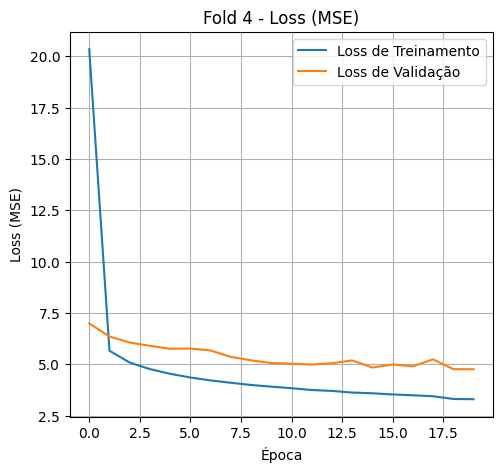


Avaliação do Fold 4 no conjunto de validação:
Loss (MSE): 4.7561
Salvando modelo do fold 4 em: submodels/submodel_fold_4.keras

--- Iniciando Fold 5/5 ---
Epoch 1/20
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 196s 77ms/step - loss: 51.6550 - val_loss: 4.6326 - learning_rate: 3.0000e-07
Epoch 2/20
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 6.3369 - val_loss: 4.2674 - learning_rate: 3.0000e-07
Epoch 3/20
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 5.6379 - val_loss: 4.2896 - learning_rate: 3.0000e-07
Epoch 4/20
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 5.2117 - val_loss: 3.8206 - learning_rate: 3.0000e-07
Epoch 5/20
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - loss: 4.9958 - val_loss: 3.6942 - learning_rate: 3.0000e-07
Epoch 6/20
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 4.7567 - val_loss: 3.6301 - learning_rate: 3.0000e-07
Epoch 7/20
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - loss: 4.5761 - val_loss: 3.9966 - learning_rate: 3.0000e-07
Epoch 8/20

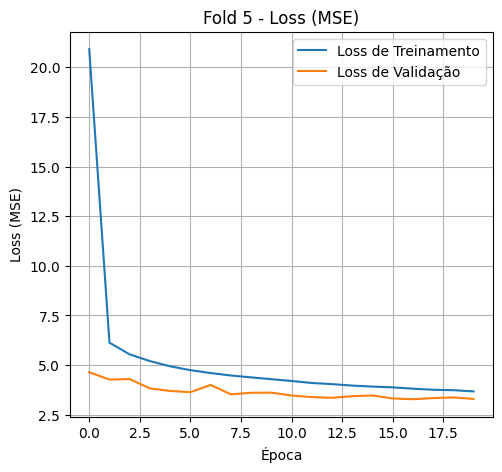


Avaliação do Fold 5 no conjunto de validação:
Loss (MSE): 3.2763
Salvando modelo do fold 5 em: submodels/submodel_fold_5.keras

--- Resumo dos Resultados do K-Fold ---
Fold 1: Loss (MSE) = 4.1787
Fold 2: Loss (MSE) = 4.3004
Fold 3: Loss (MSE) = 3.7571
Fold 4: Loss (MSE) = 4.7561
Fold 5: Loss (MSE) = 3.2763
Média da Loss (MSE) de Validação nos 5 Folds: 4.0537


In [13]:
times_trainval = np.load(times_trainval_path, allow_pickle=True) 
dates_trainval = np.array([ts.date() for ts in times_trainval]) 
unique_dates_trainval = sorted(list(set(dates_trainval))) 
date_to_indices_trainval = {date: np.where(dates_trainval == date)[0] 
                   for date in unique_dates_trainval}

lr = 3e-7
bs = 128

avg_loss, fold_histories, submodel_paths = cross_val(
    model_builder=build_resnet,
    unique_dates=unique_dates_trainval,
    date_to_indices=date_to_indices_trainval,
    learning_rate=lr,
    batch_size=bs,
    reduce_lr_patience=3,
    earlystop_patience=5,
    num_epochs=20,
    k_splits=5  
)

In [12]:
from sklearn.metrics import mean_squared_error


times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...] 

images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

submodel_paths = [os.path.join('submodels', f'submodel_fold_{i}.keras') for i in range(1, 6)]

final_predictions = predict_with_ensemble(
    model_paths=submodel_paths,
    test_images_np=images_log_test,
    batch_size=200 
)

test_rmse = np.sqrt(mean_squared_error(pv_log_test, final_predictions))

print('-'*51)
print(f"RMSE Final do Ensemble no Conjunto de Teste: {test_rmse:.4f}")

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)

Iniciando predição com ensemble de 5 modelos...
Carregando e prevendo com o modelo: submodels/submodel_fold_1.keras


I0000 00:00:1751979841.217352      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1751979848.423503      97 service.cc:148] XLA service 0x79a56000fda0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751979848.424204      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751979849.017408      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/71 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

I0000 00:00:1751979852.327221      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_2.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_3.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_4.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step
Carregando e prevendo com o modelo: submodels/submodel_fold_5.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step
Predição com ensemble concluída.
---------------------------------------------------
RMSE Final do Ensemble no Conjunto de Teste: 2.7570


### Comparação de desempenho para dias nublados e ensolarados.

In [15]:
# Definição dos dias ensolarados e nublados para análise
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

# Criação de máscaras para separar os dados de dias ensolarados e nublados
mask = np.zeros(len(pv_log_test), dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]] = 1

# Aplica a máscara para obter os subconjuntos de dados
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
predictions_ensemble_sunny = final_predictions[mask] 
print("times_test_sunny.shape:", times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
predictions_ensemble_cloudy = final_predictions[~mask]
print("times_test_cloudy.shape:", times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [16]:
from sklearn.metrics import mean_absolute_error

# Cálculo do RMSE e MAE para cada tipo de dia
rmse_sunny = np.sqrt(mean_squared_error(pv_log_test_sunny, predictions_ensemble_sunny))
rmse_cloudy = np.sqrt(mean_squared_error(pv_log_test_cloudy, predictions_ensemble_cloudy))
rmse_overall = np.sqrt(mean_squared_error(pv_log_test, final_predictions))

mae_sunny = mean_absolute_error(pv_log_test_sunny, predictions_ensemble_sunny)
mae_cloudy = mean_absolute_error(pv_log_test_cloudy, predictions_ensemble_cloudy)
mae_overall = mean_absolute_error(pv_log_test, final_predictions)

print(f"RMSE para dias ensolarados: {rmse_sunny:.3f}")
print(f"RMSE para dias nublados: {rmse_cloudy:.3f}")
print(f"RMSE geral no conjunto de teste: {rmse_overall:.3f}")

print(f"\nMAE para dias ensolarados: {mae_sunny:.3f}")
print(f"MAE para dias nublados: {mae_cloudy:.3f}")
print(f"MAE geral no conjunto de teste: {mae_overall:.3f}")

RMSE para dias ensolarados: 0.917
RMSE para dias nublados: 3.786
RMSE geral no conjunto de teste: 2.757

MAE para dias ensolarados: 0.631
MAE para dias nublados: 2.642
MAE geral no conjunto de teste: 1.639


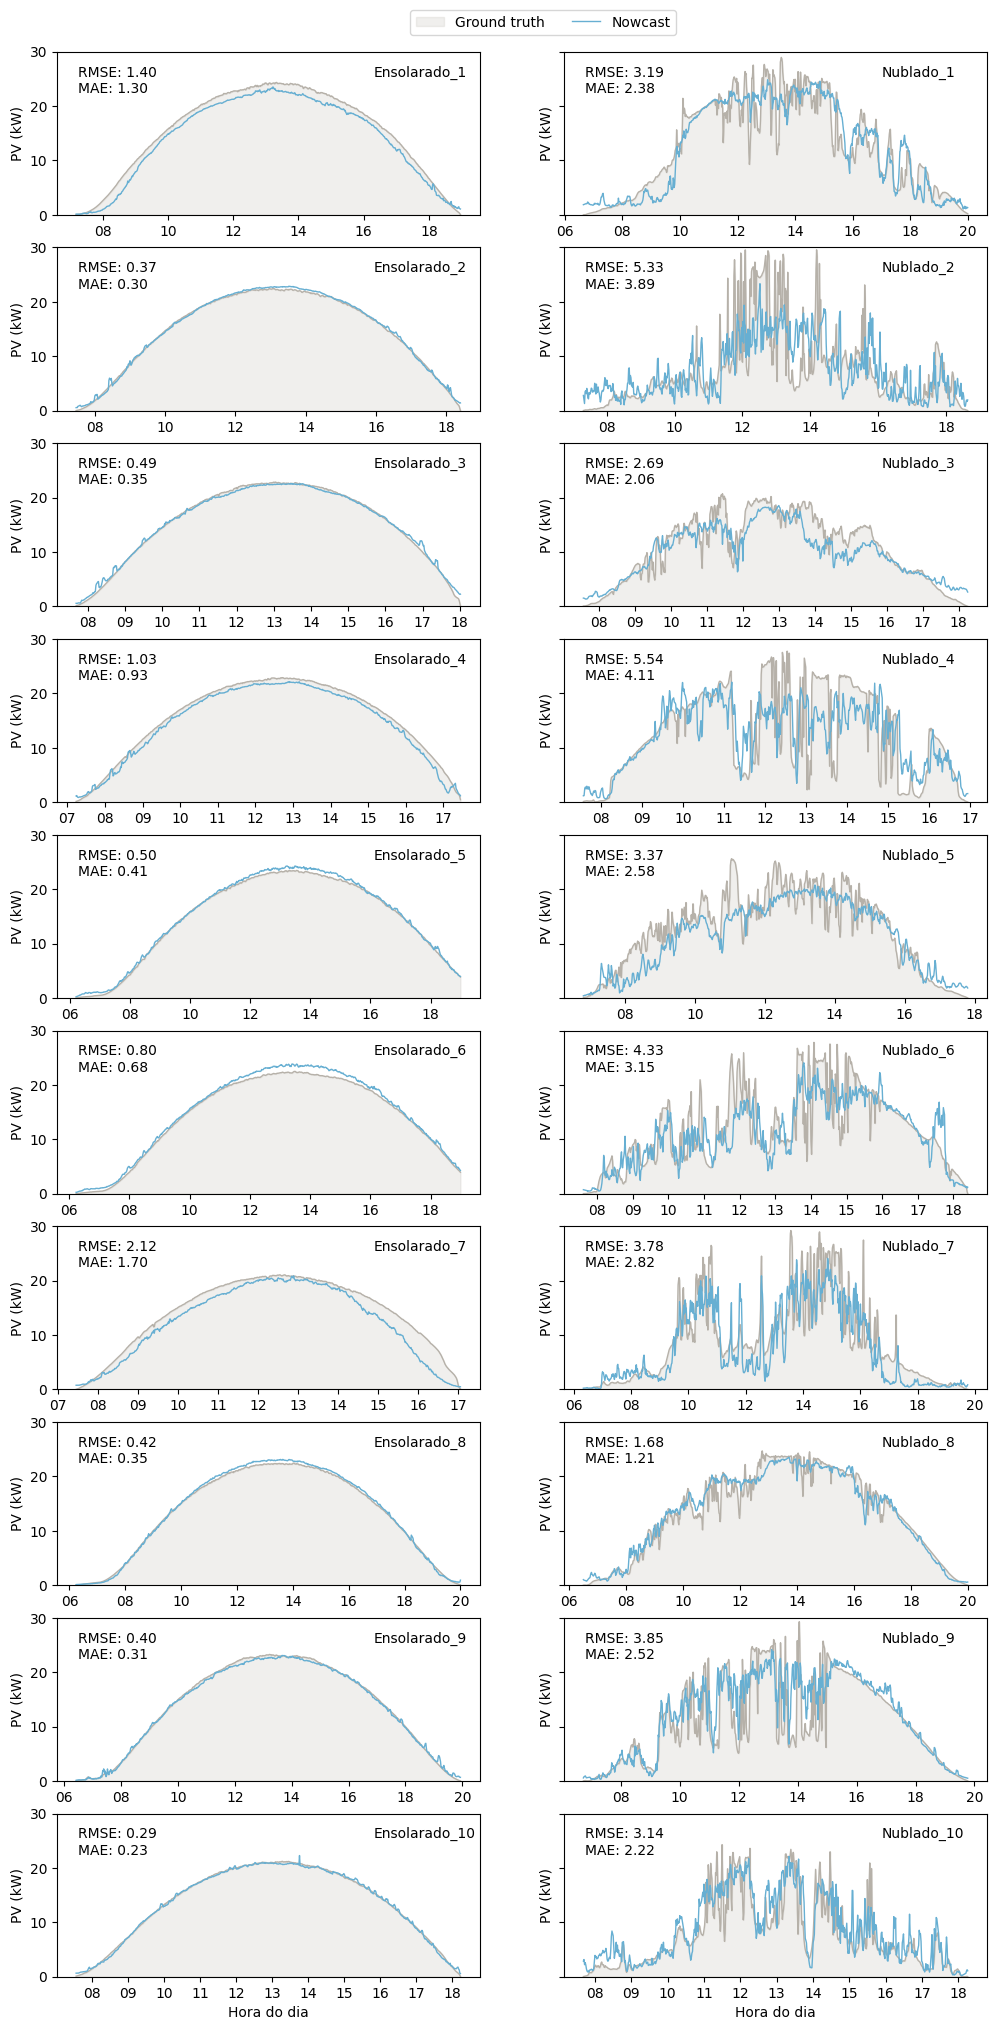

In [17]:
import matplotlib.dates as mdates

# Visualização das previsões dia a dia
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f, axarr = plt.subplots(10, 2, sharey=True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000, 1, 1)

blue = '#67AFD2'
grey = '#B6B1A9'

# Loop para dias ensolarados
for i, date in enumerate(sunny_dates_test):
    ax = axarr[i, 0]
    date_mask = (dates_test == date)
    hours_xaxis = [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]
    
    rmse = np.sqrt(mean_squared_error(pv_log_test[date_mask], final_predictions[date_mask]))
    mae = mean_absolute_error(pv_log_test[date_mask], final_predictions[date_mask])
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth=1, color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label='Ground truth')
    ax.plot(hours_xaxis, final_predictions[date_mask], linewidth=1, label='Nowcast', color=blue, markerfacecolor="None")
    ax.set_ylabel('PV (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75, 0.85, 'Ensolarado_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05, 0.75, f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}", transform=ax.transAxes)

# Loop para dias nublados
for i, date in enumerate(cloudy_dates_test):
    ax = axarr[i, 1]
    date_mask = (dates_test == date)
    hours_xaxis = [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]
    
    rmse = np.sqrt(mean_squared_error(pv_log_test[date_mask], final_predictions[date_mask]))
    mae = mean_absolute_error(pv_log_test[date_mask], final_predictions[date_mask])
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth=1, color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label='Ground truth')
    ax.plot(hours_xaxis, final_predictions[date_mask], linewidth=1, label='Nowcast', color=blue, markerfacecolor="None")
    ax.set_ylabel('PV (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75, 0.85, 'Nublado_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05, 0.75, f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}", transform=ax.transAxes)

# Configurações finais do plot
axarr[0, 0].set_ylim(0, 30)
axarr[0, 0].legend(bbox_to_anchor=[1.15, 1.3], loc='upper center', ncol=2)
axarr[-1, 0].set_xlabel('Hora do dia')
axarr[-1, 1].set_xlabel('Hora do dia')

f.set_size_inches(12, 25)
plt.show()